Simulate a joints with different divergences from a "smooth" motion.

In [48]:
# Set the folder where all (temporary) files and folders will be saved

data_folder = './data1000/'

## Set UP

Import the necessary modules

In [49]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import skimage.io as skio

import subprocess
import os
from pathlib import Path
import sys

from tqdm import tqdm
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding

from knee_joints import Knee_Joints, Joints
from knee_joints import create_fig, diagram_convert, get_distance_matrix, get_max_pw_dist

Create the necessary folders if the data is not given yet

In [50]:
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

create_folders = ['animation', 'arrays', 'distances', 'images', 'plots', 'tmp_files']
for cr_folder in create_folders:
    folderpath = os.path.join(data_folder, cr_folder)
    if not os.path.isdir(folderpath):
        print('Created folder', folderpath)
        # os.mkdir(folderpath)

## Simulating joints

Simulate the knee and several joints and save the results as images as well as coordinate matrices of the joints.

In [51]:
periodicity = 100
number_steps = 1000
limit_plot = 1000
overwrite = False
redo = False

do_image_plots = True

params = {'folder': -1,
          'move_method': -1,
          'noise': 0,
          'bandwidth': 0,
          'time_updater': 1}

samples = [{'folder': 'images_smooth',
            'move_method': 'sinoidal'},
           # quicker pace
           {'folder': 'images_smooth_quick',
            'move_method': 'sinoidal',
            'time_updater': 5},
            # {'folder': 'images_smooth_quick',
            # 'move_method': 'sinoidal',
            # 'time_updater': 20},
           # noisy
           {'folder': 'images_noisy',
            'move_method': 'sinoidal_noise',
            'noise': 0.01},
           {'folder': 'images_noisy',
            'move_method': 'sinoidal_noise',
            'noise': 0.1},
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0,
            'bandwidth': 0.1},
           # last point
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0.1,
            'bandwidth': 0.1},
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0.01,
            'bandwidth': 0.1},
           # skip
           {'folder': 'images_skip',
            'move_method': 'skip_overextension',
            'noise': 0,
            'bandwidth': 0.1},
           {'folder': 'images_skip',
            'move_method': 'skip_overextension',
            'noise': 0.1,
            'bandwidth': 0.1}
           ]

Perfom the simulation of the joints and save the resulting figures in the appropriate subfolder in `images` and the resulting array of x,y coordinates of each joint in `arrays`.

In this example the joints are:

> `kj = Knee_Joints(number_steps=periodicity)` 
> `kj.add_point_relative(xborder=[-0.25, 0.25])`
> `kj.add_point_relative(xborder=[-0.5, 0.5])`
> `kj.add_point_relative(xborder=[-1, 1])`

In [52]:
samples_pts = []
pbar = tqdm(samples)
# for folder, move_method, noise, bandwidth in pbar:
for sample in pbar:
    for i, key in enumerate(params):
        if key not in sample:
            if params[key] == -1:
                raise ValueError(f'{key} needs to be set!')
            else:
                sample[key] = params[key]

    # TODO need to copy these into the fields below
    folder = sample['folder']
    move_method = sample['move_method']
    noise = sample['noise']
    bandwidth = sample['bandwidth']
    time_updater = sample['time_updater']

    # find the right folder name and filename
    if noise > 0:
        folder = f'{folder}_{noise}'

    # if we have no noise and overwrite is not True take the next one
    if (((noise == 0 and not overwrite) or (not redo))
       and os.path.isdir(os.path.join(data_folder, 'images', folder))
       and os.path.isfile(os.path.join(data_folder, 'arrays', f'{folder}.npy'))):

        print(f'  {folder} exists already, skip')
        continue

    found_folder = False
    step = 1
    folder_loop = folder
    while not found_folder:
        if not os.path.isdir(os.path.join(data_folder, 'images', folder_loop)):
            os.mkdir(os.path.join(data_folder, 'images', folder_loop))
            found_folder = True
        elif not overwrite and os.path.isfile(os.path.join(data_folder, 'images', 
                                                           f'{folder_loop}.npy')):
            folder_loop = f'{folder}_{step}'
            step += 1
        else:
            found_folder = True
    folder = folder_loop

    # update progressbar
    pbar.set_description(f'processing: {folder}')


    ##### CREATION OF THE CONSTRUCT; SAME BASELINE FOR ALL OF THEM
    # construct the knee joint
    kj = Knee_Joints(number_steps=periodicity)
    kj.add_point_relative(xborder=[-0.25, 0.25])
    kj.add_point_relative(xborder=[-0.5, 0.5])
    kj.add_point_relative(xborder=[-1, 1])

    kj.save_current()

    for move in range(number_steps - 1):
        kj.move_joint(method=move_method,
                      noise_size=noise,
                      bandwidth=bandwidth, 
                      time_updater=time_updater)

    points = kj.get_history_array()
    np.save(os.path.join(data_folder, 'arrays', f'{folder}.npy'), points)
    samples_pts.append(points)

    if do_image_plots:
        n_joints = len(kj.points)
        bbox = kj.get_bounding_box()

        for j, points in enumerate(kj.history):
            if j >= limit_plot:
                break
            fig, ax = plt.subplots(1, 1, dpi=200)
            G = nx.Graph()

            keys = list(points.keys())
            G.add_nodes_from(keys)
            G.add_edges_from([(keys[i], keys[i+1])
                            for i in range(len(keys)-1)])

            pos = [points[key] for key in keys]
            nx.draw(G, pos, ax=ax)
            # ax.set_title(' '.join(folder.split('_')[1:]))
            ax.set_xlim(left=bbox[0]-1, right=bbox[1]+1)
            ax.set_ylim(bottom=bbox[2]-1, top=bbox[3]+1)

            fig.savefig(os.path.join(data_folder, 'images', 
                                     f'{folder}/movement_{j:04d}.png'))
            plt.close(fig)

100%|██████████| 9/9 [00:00<00:00, 5653.55it/s]

  images_smooth exists already, skip
  images_smooth_quick exists already, skip
  images_noisy_0.01 exists already, skip
  images_noisy_0.1 exists already, skip
  images_last-point exists already, skip
  images_last-point_0.1 exists already, skip
  images_last-point_0.01 exists already, skip
  images_skip exists already, skip
  images_skip_0.1 exists already, skip


### GIF creation
Get the folder for which images and arrays were created and create the gif if the file doesn't already exist

In [53]:
# # get the folders

# folders = []
# for item in Path('/data/images').iterdir():
#     if (item.is_dir()
#        and str(item.name).startswith('images_')):
#         # if not os.path.isfile(os.path.join('arrays', f'{item.name}.npy')):
#         #     print(f"  {item.name} doesn't have an associated array!")
#         # else:
#         folders.append(item.name)

# # get the gifs

# pbar = tqdm(folders)
# for folder in pbar:
#     if not os.path.isfile(f'/data/animation/anim_{folder}.gif'):
#         pbar.set_description(f'processing: {folder}')
#         call = ['convert', '-scale', '50%',
#                 '-delay', '10', '-loop', '0',
#                 f'data/images/{folder}/*.png', f'/data/animation/anim_{folder}.gif']
#         subprocess.call(call)

## Persistence computation

Calculate the persistence for the different combinations. 
Plot the different steps later.

In [54]:
# get the folders

folders = []
for item in Path(data_folder, 'arrays').iterdir():
    if (str(item.name).startswith('images_')
       and str(item.name).endswith('.npy')):
        folders.append(item.name)

# sort folders and put 'images_smooth' in 
# first position if it exists
folders.sort()
if 'images_smooth.npy' in folders:
    folders.remove('images_smooth.npy')
    folders.insert(0, 'images_smooth.npy')

samples_all = [(i,
                '_'.join(folders[i].split('_')[1:]),
                np.load(os.path.join(data_folder, 'arrays', f'{folders[i]}')))
               for i in range(len(folders))]

folders = [folder[:-4] for folder in folders]

### Coordinate distance and its persistence

Get the pairwise distances using the coordinates of the joints as basis:

In [55]:
if os.path.isfile(os.path.join(data_folder, 'distances', 'distances_coords.npz')):
    distances = np.load(os.path.join(data_folder, 'distances', 'distances_coords.npz'))
    distances = distances['distances']
else:
    distances = []
    for k, txt, points_plot in samples_all:
        dist_mat = np.zeros([len(points_plot), len(points_plot)])
        for i in range(len(points_plot)):
            for j in range(i+1, len(points_plot)):
                dist_mat[i, j] = np.linalg.norm(points_plot[i] - points_plot[j])
                dist_mat[j, i] = dist_mat[i, j]
            
        distances.append(dist_mat)

    distances = np.array(distances)
    np.savez_compressed(os.path.join(data_folder, 'distances', 'distances_coords.npz'), 
                        names=[folder for folder in folders],
                        distances=distances)

Difference of consecutive points

In [56]:
l2_coords = []
for _, _, points_plot in samples_all:
    l2_coords.append([np.linalg.norm(points_plot[i+1] - points_plot[i])
                      for i in range(points_plot.shape[0]-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2_coords)

Alpha complex and Vietoris Rips complex computation for consecutive distances

In [57]:
if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_alphacomplex.npz')):
    arr_dgm = []
    for i in range(len(pc_taken)):
        acX = gd.AlphaComplex(points=pc_taken[i]).create_simplex_tree()
        dgmX = acX.persistence()
        arr_dgm.append(diagram_convert(dgmX))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_alphacomplex.npz'), **tmp_dict)

In [58]:
# this can take a while, hence save the intermediate results
# on my machine ~ 1.40min per iteration

if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_VRcomplex.npz')):
    for i in tqdm(range(len(pc_taken))):
        if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy')):
            acX = gd.RipsComplex(points=pc_taken[i]).create_simplex_tree(max_dimension=2)
            dgmX = acX.persistence()
            np.save(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy'), diagram_convert(dgmX))

    arr_dgm = []
    for i in tqdm(range(len(pc_taken))):
        arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy')))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_VRcomplex.npz'), **tmp_dict)


for i in tqdm(range(len(pc_taken))):
    if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy')):
        print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy'))
        os.remove(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy'))

100%|██████████| 9/9 [00:00<00:00, 12079.60it/s]


In [59]:
# this can take a while, hence save the intermediate results
# on my machine ~ 1.30min per iteration

if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'coords_distmatrix_VRcomplex.npz')):
    for i in tqdm(range(len(distances))):
        if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy')):
            acX = gd.RipsComplex(distance_matrix=distances[i]).create_simplex_tree(max_dimension=2)
            dgmX = acX.persistence()
            np.save(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy'), diagram_convert(dgmX))

    arr_dgm = []
    for i in tqdm(range(len(pc_taken))):
        arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy')))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'coords_distmatrix_VRcomplex.npz'), **tmp_dict)


for i in tqdm(range(len(pc_taken))):
    if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy')):
        print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy'))
        os.remove(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy'))

100%|██████████| 9/9 [00:00<00:00, 16159.56it/s]


### image distance

Now we use the distances of the images as input in the alpha and vietoris rips complexes

Get the pairwise distances of the images as matrices:

In [60]:
if os.path.isfile(os.path.join(data_folder, 'distances', 'distances_images.npz')):
    distances_images = np.load(os.path.join(data_folder, 'distances', 'distances_images.npz'))
    names = distances_images['names']
    distances_images = distances_images['distances']
else:
    distances_images = []
    for folder in folders:
        files = os.listdir(os.path.join(data_folder, f'images/{folder}'))
        files.sort()

        print(folder)
        print(' - Read in images')
        images = []
        for file in tqdm(files):
            img = skio.imread(os.path.join(data_folder, f'images/{folder}/{file}'))[:, :, :3]
            img = np.uint8(rgb2gray(img))
            images.append(np.array(img < 1, dtype=np.int32))

        print(' - Create distance matrix')
        dist_mat = np.zeros([len(images), len(images)])
        for i in tqdm(range(len(images))):
            for j in range(i+1, len(images)):
                dist_mat[i, j] = np.linalg.norm(images[i] - images[j])
                dist_mat[j, i] = dist_mat[i, j]
            
        distances_images.append(dist_mat)

    distances_images = np.array(distances_images)
    np.savez_compressed(os.path.join(data_folder, 'distances', 'distances_images.npz'),
                        names=[folder for folder in folders],
                        distances=distances_images)

In [61]:
# Get the difference of consecutive images
l2_images = []
for k, _ in enumerate(folders):
    l2_images.append([np.linalg.norm(distances_images[k][i+1, i])
               for i in range(len(distances_images[k])-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2_images)

Alpha complex complex computation for consecutive distances

In [62]:
if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_alphacomplex.npz')):
    arr_dgm = []
    for i in range(len(pc_taken)):
        acX = gd.AlphaComplex(points=pc_taken[i]).create_simplex_tree()
        dgmX = acX.persistence()
        arr_dgm.append(diagram_convert(dgmX))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_alphacomplex.npz'), **tmp_dict)

Vietoris Rips complex computation for consecutive distances

In [63]:
# this can take a while, hence save the intermediate results
# on my machine it taskes ~1:20 per iteration
if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_VRcomplex.npz')):
    for i in tqdm(range(len(pc_taken))):
        if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy')):

            acX = gd.RipsComplex(points=pc_taken[i]).create_simplex_tree(max_dimension=2)
            dgmX = acX.persistence()
            np.save(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy'), diagram_convert(dgmX))

    arr_dgm = []
    for i in tqdm(range(len(pc_taken))):
        arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy')))

    names = [folder for folder in folders]
    tmp_dict = {names[i]: arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_VRcomplex.npz'), **tmp_dict)


for i in tqdm(range(len(pc_taken))):
    if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy')):
        print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy'))
        os.remove(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy'))

100%|██████████| 9/9 [00:00<00:00, 15981.68it/s]


Vietoris Rips complex computation for pairwise distances

In [64]:
# THIS TAKES FAR TOO LONG!

# # this can take a while, hence save the intermediate results

# if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'images_distmatrix_VRcomplex.npz')):
#     for i in tqdm(range(len(distances_images))):
#         if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy')):
#             acX = gd.RipsComplex(distance_matrix=distances_images[i]).create_simplex_tree(max_dimension=2)
#             dgmX = acX.persistence()
#             np.save(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy'), diagram_convert(dgmX))

#     arr_dgm = []
#     for i in tqdm(range(len(distances_images))):
#         arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy')))

#     names = [folder for folder in folders]
#     tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
#     np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'images_distmatrix_VRcomplex.npz'), **tmp_dict)


# for i in tqdm(range(len(distances_images))):
#     if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy')):
#         print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy'))
#         os.remove(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy'))

# Plots

In [65]:
# get the folders

folders = []
for item in Path(data_folder, 'arrays').iterdir():
    if (str(item.name).startswith('images_')
       and str(item.name).endswith('.npy')):
        folders.append(item.name)

# sort folders and put 'images_smooth' in 
# first position if it exists
folders.sort()
if 'images_smooth.npy' in folders:
    folders.remove('images_smooth.npy')
    folders.insert(0, 'images_smooth.npy')

samples_all = [(i,
                '_'.join(folders[i].split('_')[1:]),
                np.load(os.path.join(data_folder, 'arrays', f'{folders[i]}')))
               for i in range(len(folders))]

folders = [folder[:-4] for folder in folders]

## Distance matrices

Compare the distance matrices for coordinate distance and image distance to each other

In [66]:
# fig, ax_list = create_fig(pc_taken, dpi=100)

# for i in range(len(pc_taken)):
#     mask = np.ones([len(pc_taken[i]), len(pc_taken[i])])
#     mask = (np.triu(mask, k=1)==1)
#     counts, bins = np.histogram(get_distance_matrix(pc_taken[i])[mask])
#     ax_list[i].plot(bins[1:], counts)

#     cumsum = 0
#     j = len(counts) - 1
#     while cumsum < 0.01*np.shape(pc_taken[i])[0]:
#         cumsum += counts[j]
#         j -= 1

#     ax_list[i].vlines(bins[1+j],
#                       np.min(counts), np.max(counts),
#                       color='r')
#     ax_list[i].set_title(f'{folders[i][:-4]}  -  {np.shape(pc_taken[i])[0]}')

# fig.tight_layout()

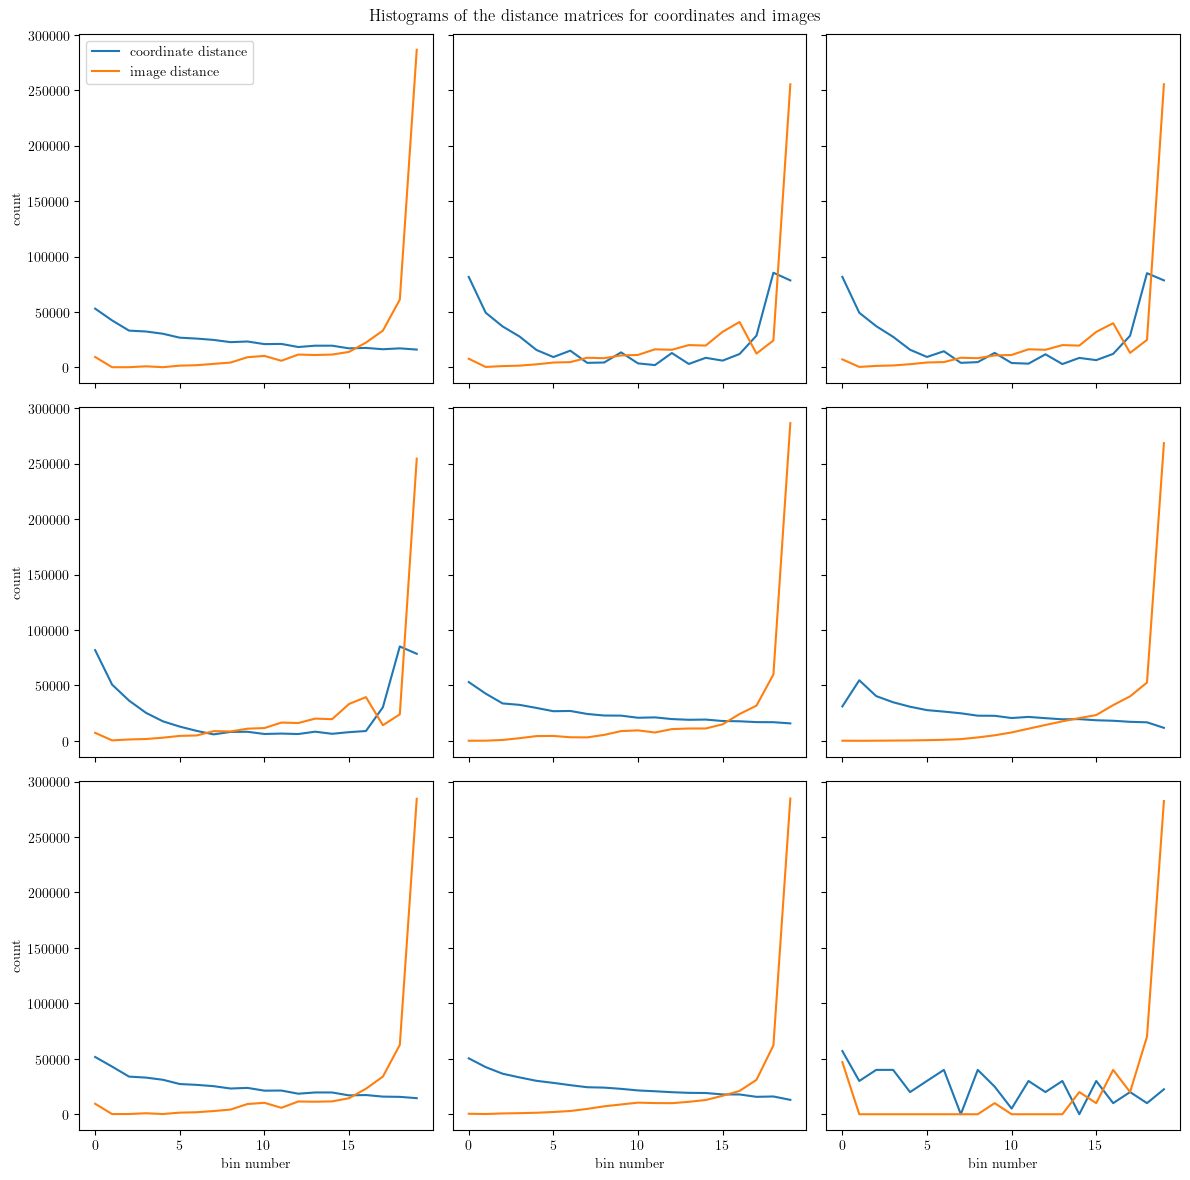

In [67]:
# for i in range(len(pc_taken)):
fig, ax_list, rows, cols = create_fig(samples_all, dpi=100,
                                      return_row_col=True,
                                      sharex=True,
                                      sharey=True)

for i in range(len(distances)):
    # mask = np.ones([len(pc_taken[i]), len(pc_taken[i])])
    # mask = (np.triu(mask, k=1)==1)
    # counts, bins = np.histogram(get_distance_matrix(pc_taken[i])[mask], bins=20)
    # ax_list[i].plot(range(20), counts, label='point distance in taken embedding')

    mask = np.ones(np.shape(distances[i]))
    mask = (np.triu(mask, k=1)==1)
    counts, bins = np.histogram(distances[i][mask], bins=20)
    ax_list[i].plot(range(20), counts, label='coordinate distance')

    mask = np.ones(np.shape(distances_images[i]))
    mask = (np.triu(mask, k=1)==1)
    counts, bins = np.histogram(distances_images[i][mask], bins=20)
    ax_list[i].plot(range(20), counts, label='image distance')

    # if the current axis is on the last row
    if i >= (rows - 1)*cols:
        ax_list[i].set_xlabel('bin number')
    # if the current axis is on the first column
    if i % cols == 0:
        ax_list[i].set_ylabel('count')
    ax_list[0].legend()

fig.suptitle('Histograms of the distance matrices for coordinates and images')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', f'histogram_{folders[i][:-4]}.png'))

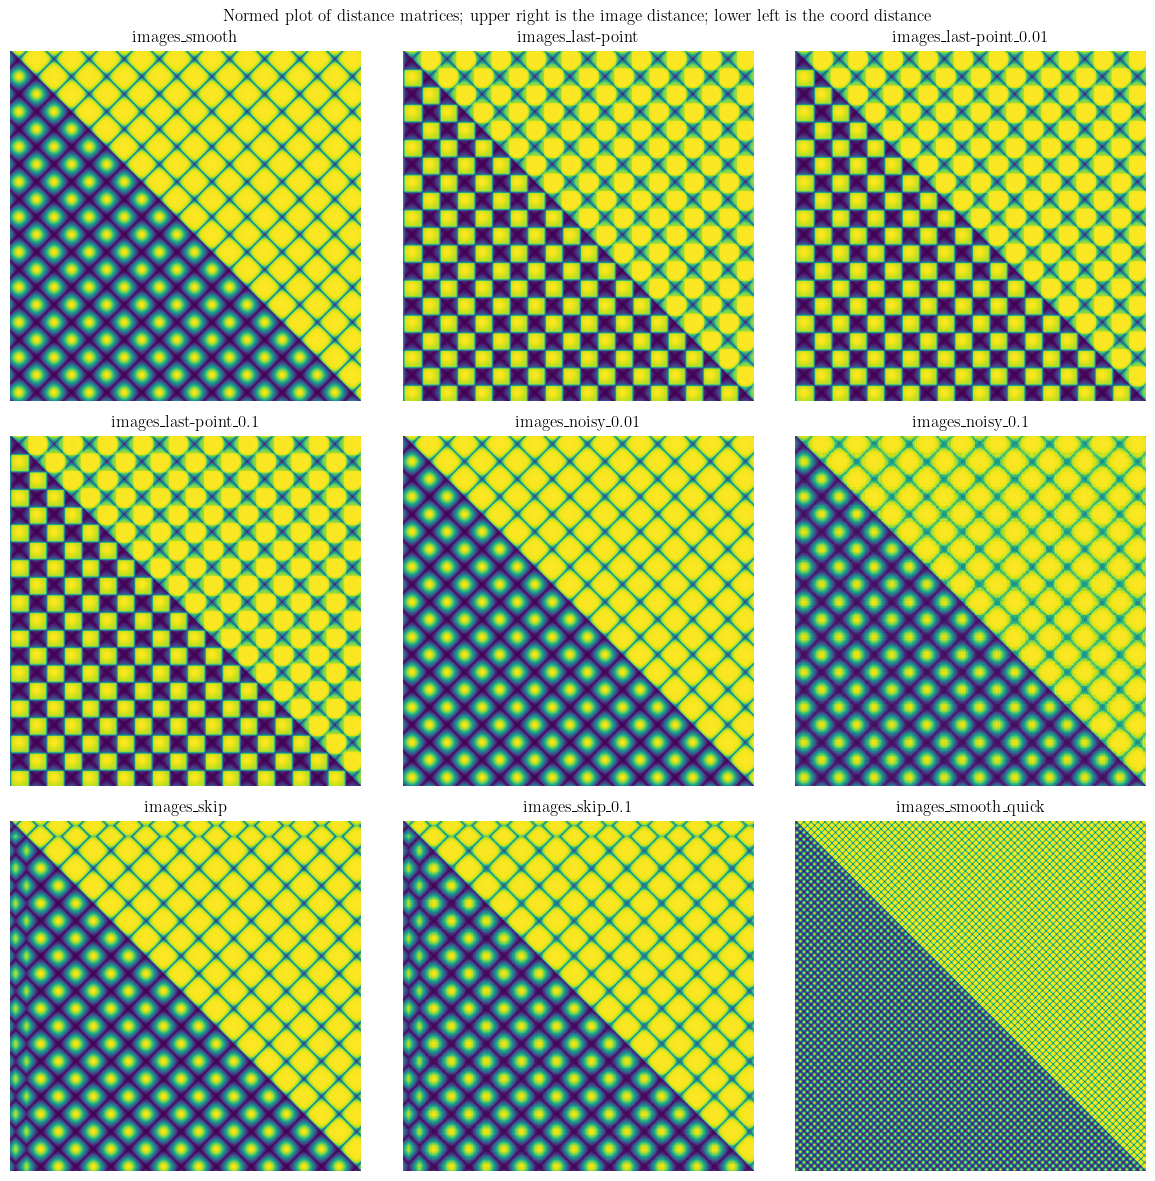

In [68]:
# distance matrices
for i in range(len(distances)):
    if np.shape(distances[i]) != np.shape(distances_images[i]):
        print(np.shape(distances[i]), np.shape(distances_images[i]))
        raise ValueError(f"distance and distance_images are not the same for {i}")

fig, ax_list = create_fig(distances, dpi=100,
                          sharex=True,
                          sharey=True)

for i in range(len(distances)):
    mask = np.ones(np.shape(distances[i]))
    mask = (np.triu(mask, k=1)==1)

    img = (distances[i] - np.min(distances[i][mask])) / (np.max(distances[i][mask]) - np.min(distances[i][mask]))

    tmp = (distances_images[i] - np.min(distances_images[i][mask])) / (np.max(distances_images[i][mask]) - np.min(distances_images[i][mask]))
    img[mask] = tmp[mask]

    ax_list[i].imshow(img)
    ax_list[i].set_title(folders[i])
    ax_list[i].axis('off')

fig.suptitle('Normed plot of distance matrices; upper right is the image distance; lower left is the coord distance')
fig.tight_layout()

fig.savefig(os.path.join(data_folder, 'plots', 'distance_matrices_coord-image-distance.png'))


## Persistence - Coordinate distance

PLot the different persistent diagrams

Get the distances between consective slices for each of the samples and their embedded point clouds

In [69]:
l2_coords = []
for _, _, points_plot in samples_all:
    l2_coords.append([np.linalg.norm(points_plot[i+1] - points_plot[i])
                      for i in range(points_plot.shape[0]-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2_coords)

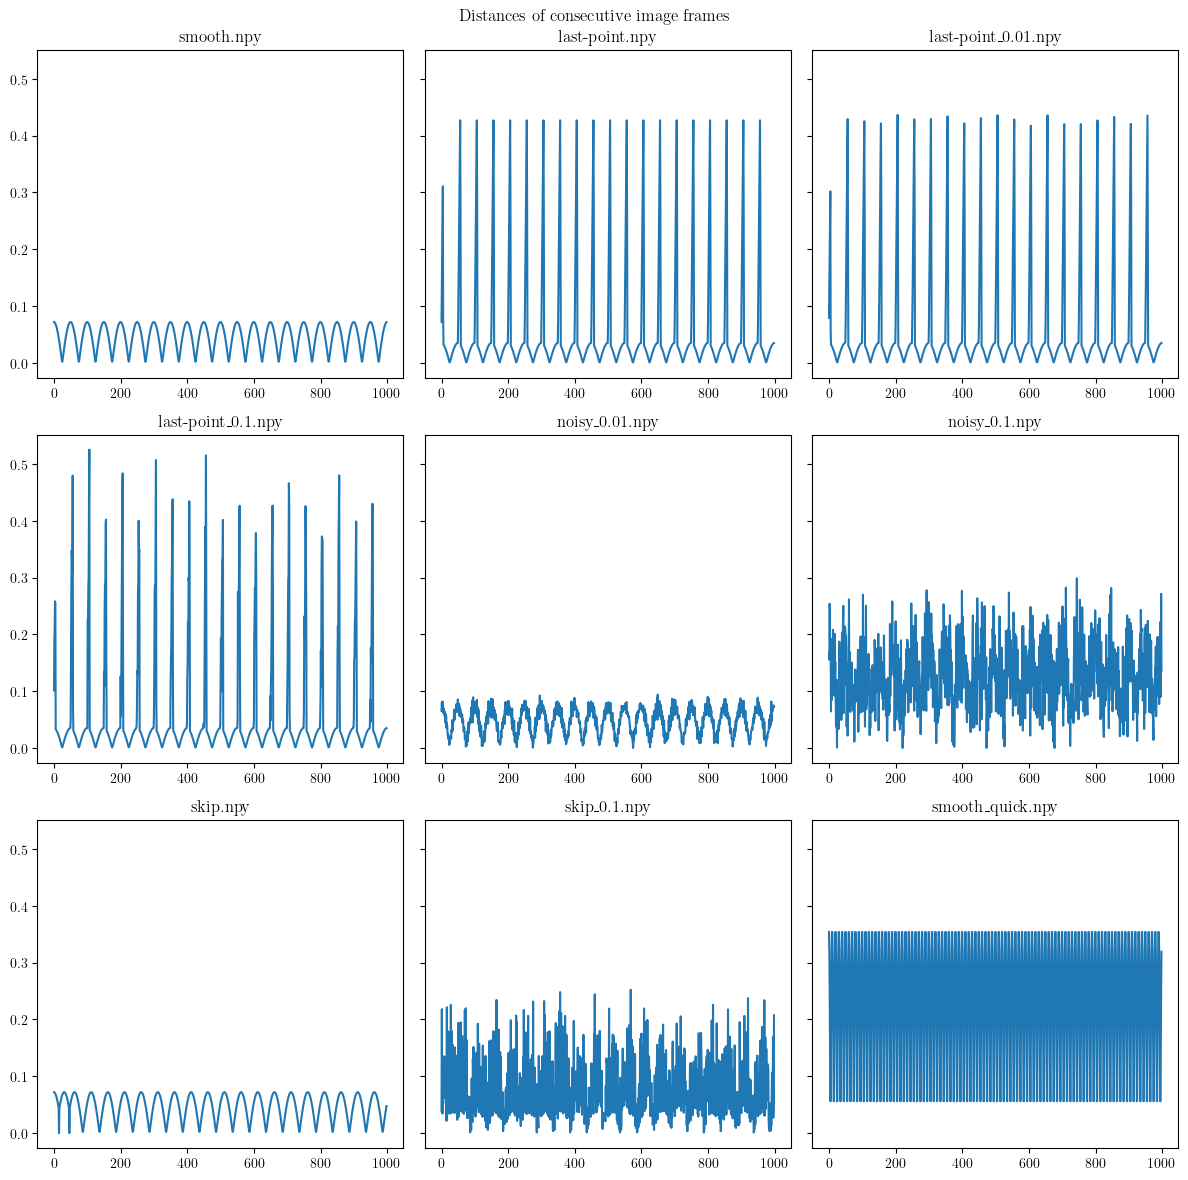

In [70]:
fig, ax_list = create_fig(samples_all, dpi=100, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].plot(range(len(l2_coords[i])), l2_coords[i])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Distances of consecutive image frames')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_distance_bw_consecutive_frames.png'))

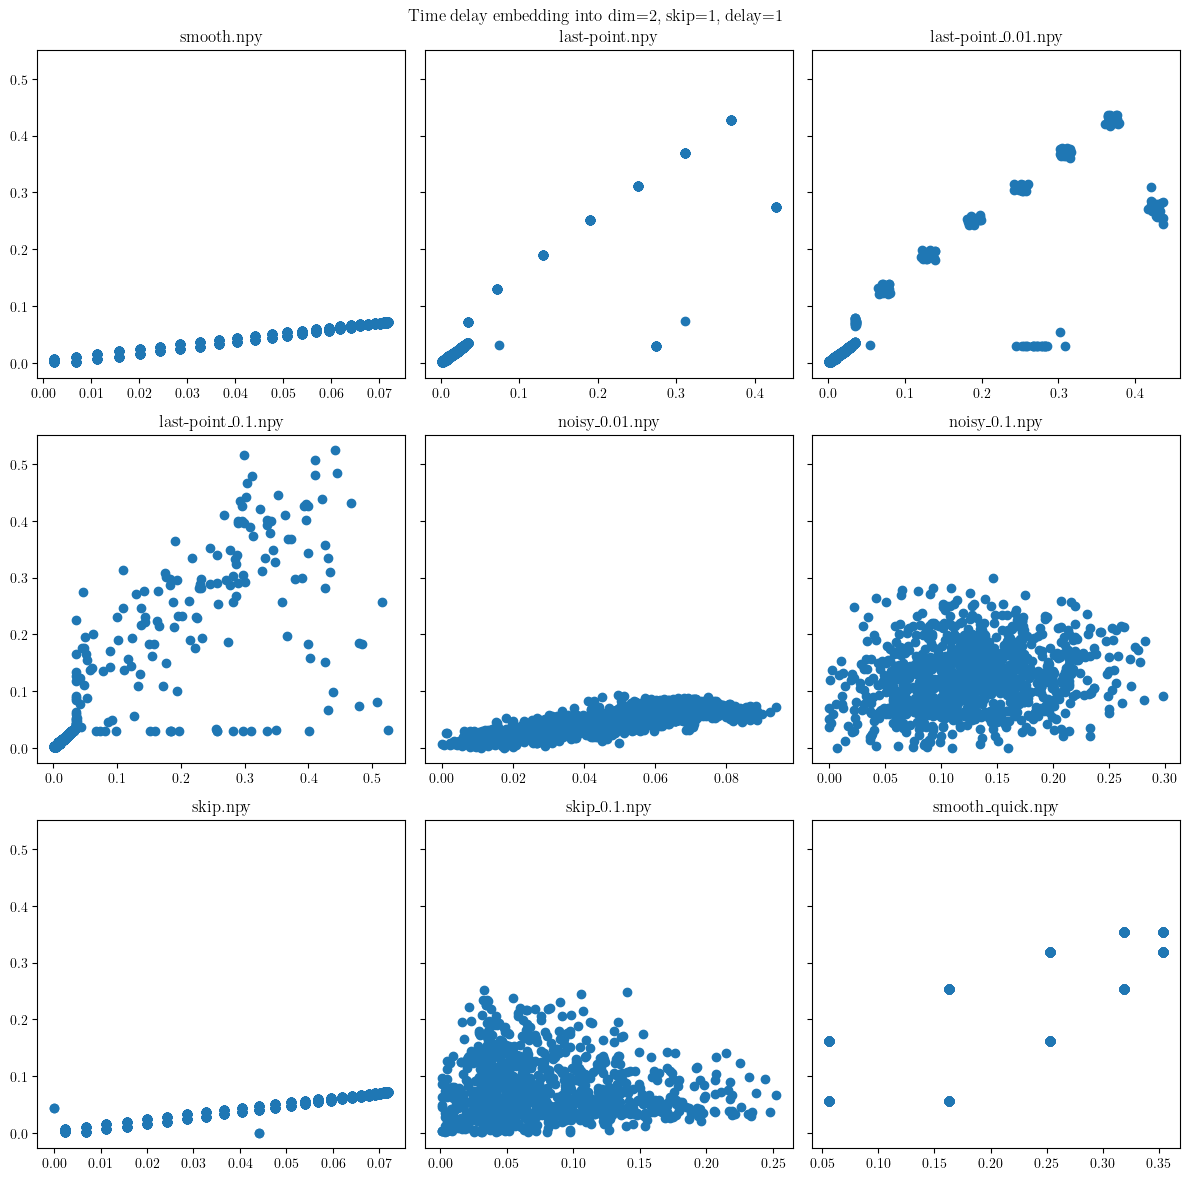

In [71]:
fig, ax_list = create_fig(samples_all, dpi=100, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].scatter(pc_taken[i][:, 0], pc_taken[i][:, 1])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Time delay embedding into dim=2, skip=1, delay=1')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_time_delay_consecutive_frames.png'))

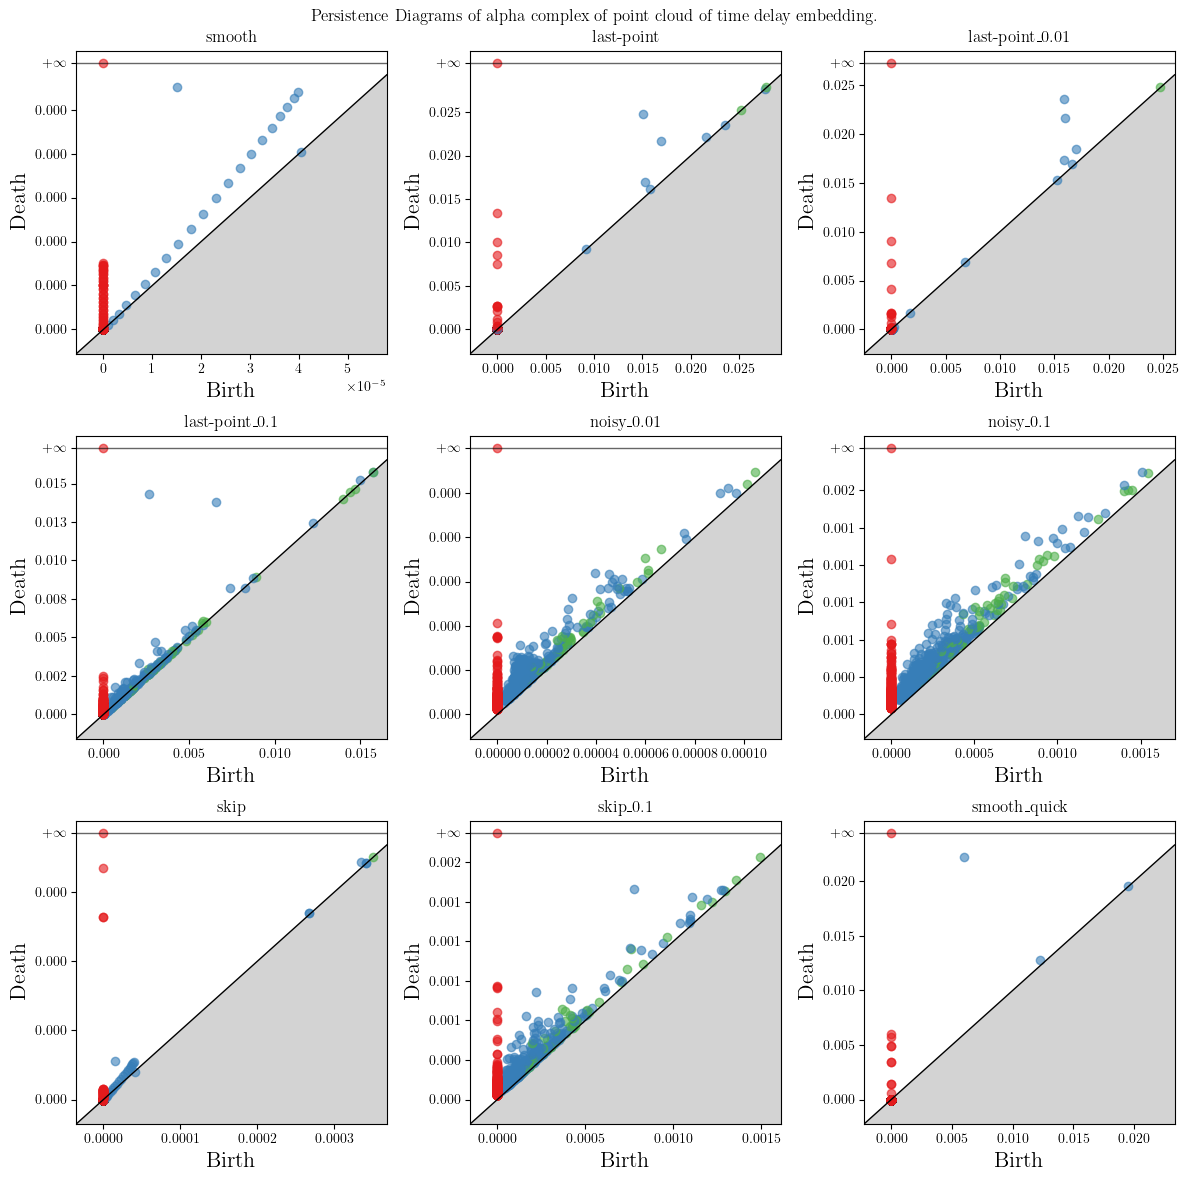

In [72]:
# fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)
fig, ax_list = create_fig(samples_all, dpi=100)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'coords_consecutive_alphacomplex.npz'))

# for i, txt, _ in samples_all:
#     print(folders[i], txt)
#     dgmX = diagram_convert(files[folders[i]])
#     gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
#     ax_list[i].set_title(txt)

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of alpha complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_alpha_timedelay.png'))

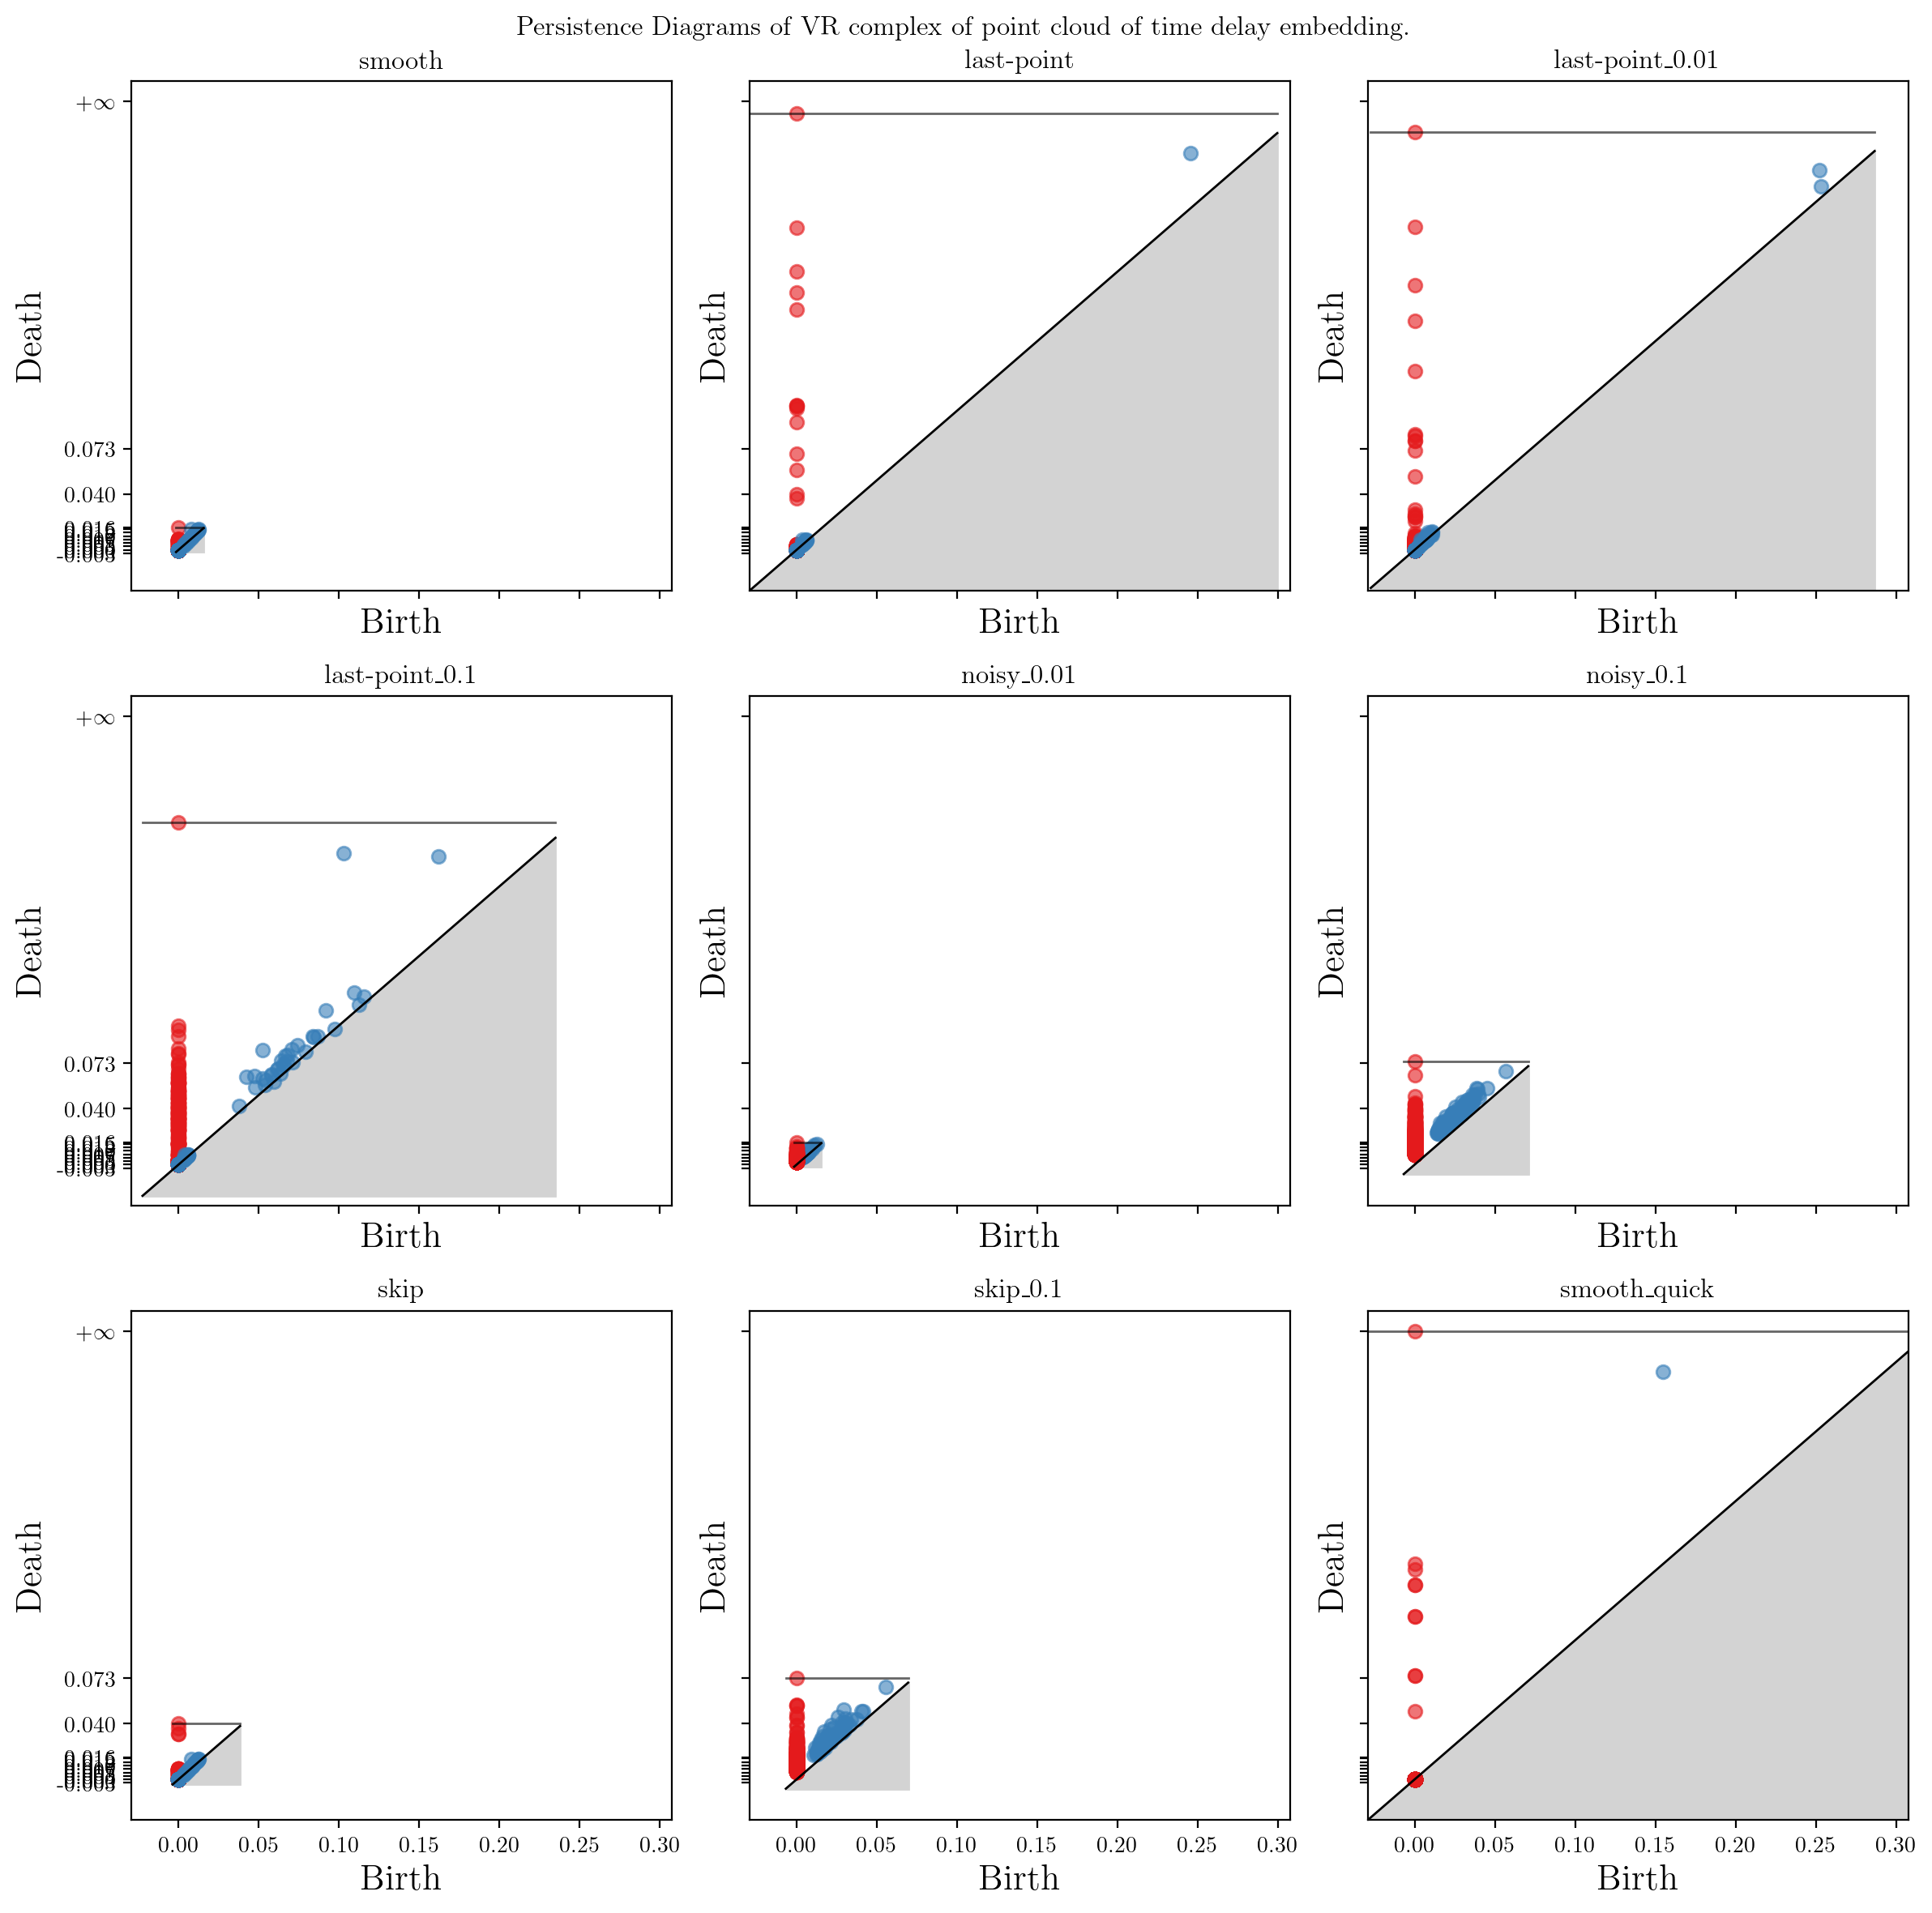

In [73]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'coords_consecutive_VRcomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))
    
for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of VR complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_VR_timedelay.png'))

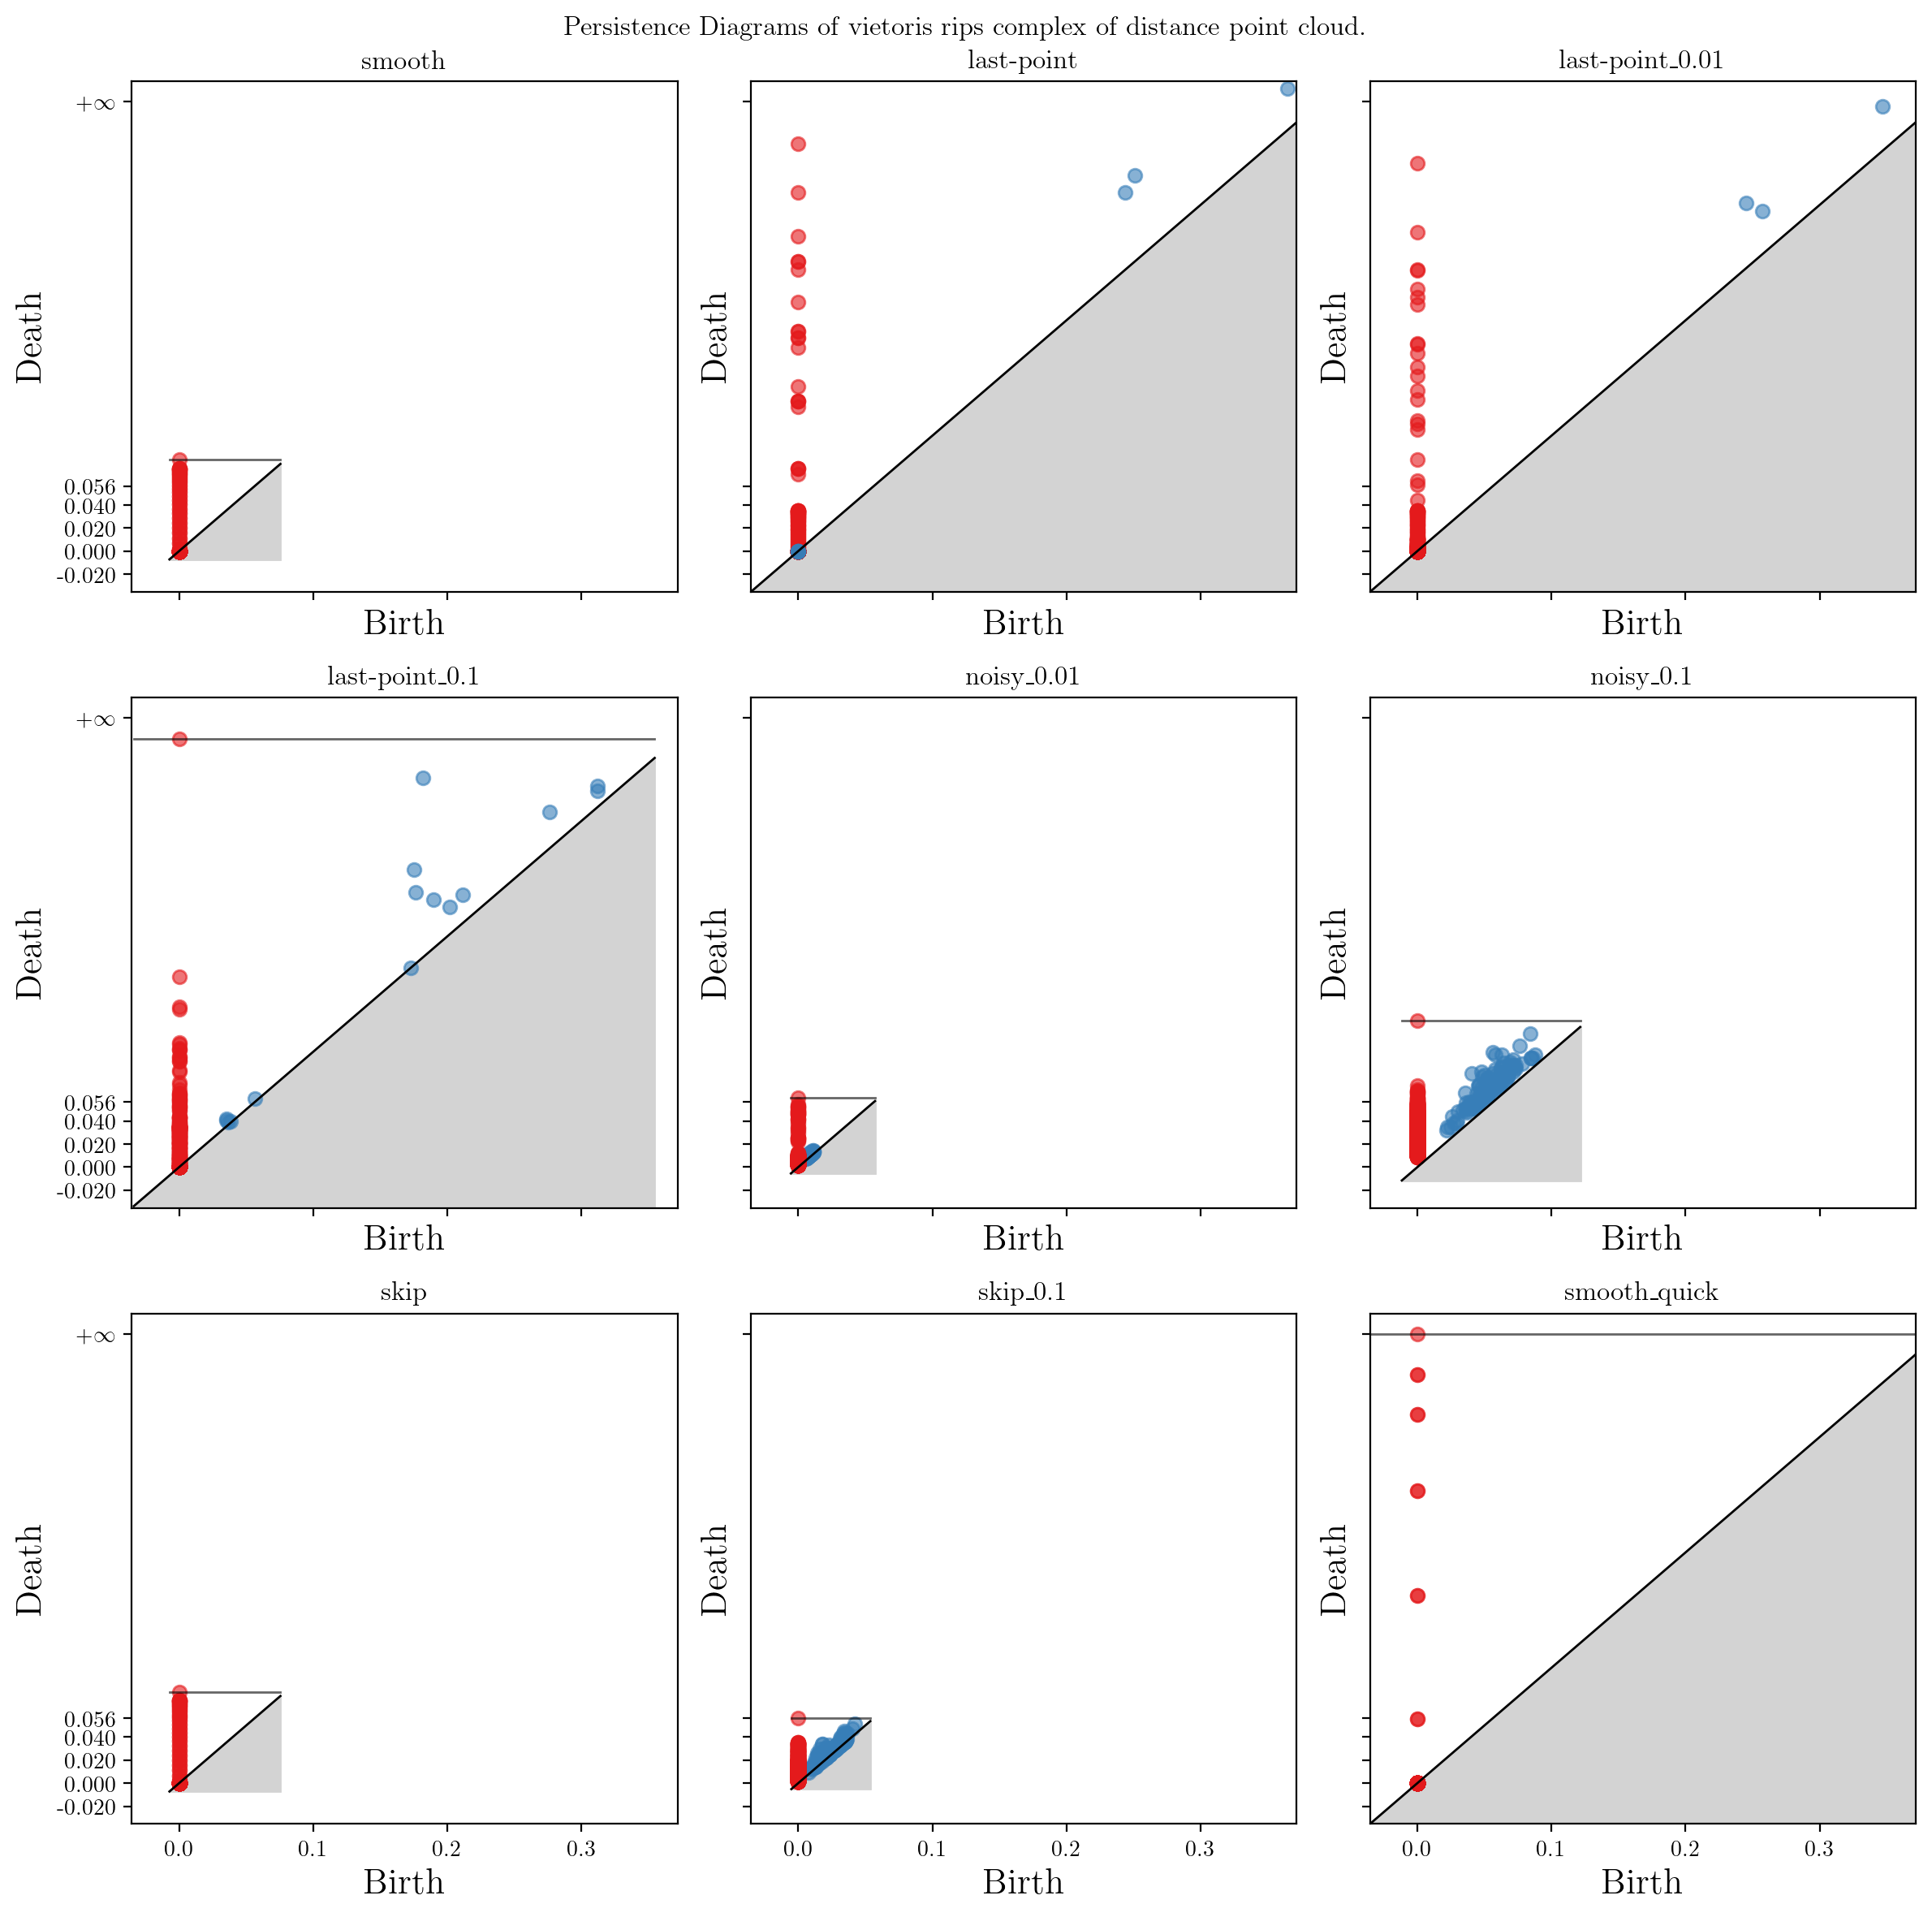

In [74]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'coords_distmatrix_VRcomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of vietoris rips complex'
             + ' of distance point cloud.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_VR_pwDistances.png'))

## Persistence - Image distance

Get the pairwise distances of the images as matrices:

In [75]:
if os.path.isfile(os.path.join(data_folder, 'distances/distances_images.npz')):
    distances_images = np.load(os.path.join(data_folder, 'distances/distances_images.npz'))
    names = distances_images['names']
    distances_images = distances_images['distances']
else:
    distances_images = []
    for folder in folders:
        files = os.listdir(os.path.join(data_folder, f'images/{folder}'))
        files.sort()

        print(folder)
        print(' - Read in images')
        images = []
        for file in tqdm(files):
            img = skio.imread(os.path.join(data_folder, f'images/{folder}/{file}'))[:, :, :3]
            img = np.uint8(rgb2gray(img))
            images.append(np.array(img < 1, dtype=np.int32))

        print(' - Create distance matrix')
        dist_mat = np.zeros([len(images), len(images)])
        for i in tqdm(range(len(images))):
            for j in range(i+1, len(images)):
                dist_mat[i, j] = np.linalg.norm(images[i] - images[j])
                dist_mat[j, i] = dist_mat[i, j]
            
        distances_images.append(dist_mat)

    distances_images = np.array(distances_images)
    np.savez_compressed(os.path.join(data_folder, 'distances', 'distances_images.npz'),
                        names=[folder for folder in folders],
                        distances=distances_images)

In [76]:
l2 = []
for k, folder in enumerate(folders):
    l2.append([np.linalg.norm(distances_images[k][i+1, i])
               for i in range(len(distances_images[k])-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2)

### Now plot the persistence diagrams (and calculate the persistence):

Distances between consecutive x,y positions for different times.

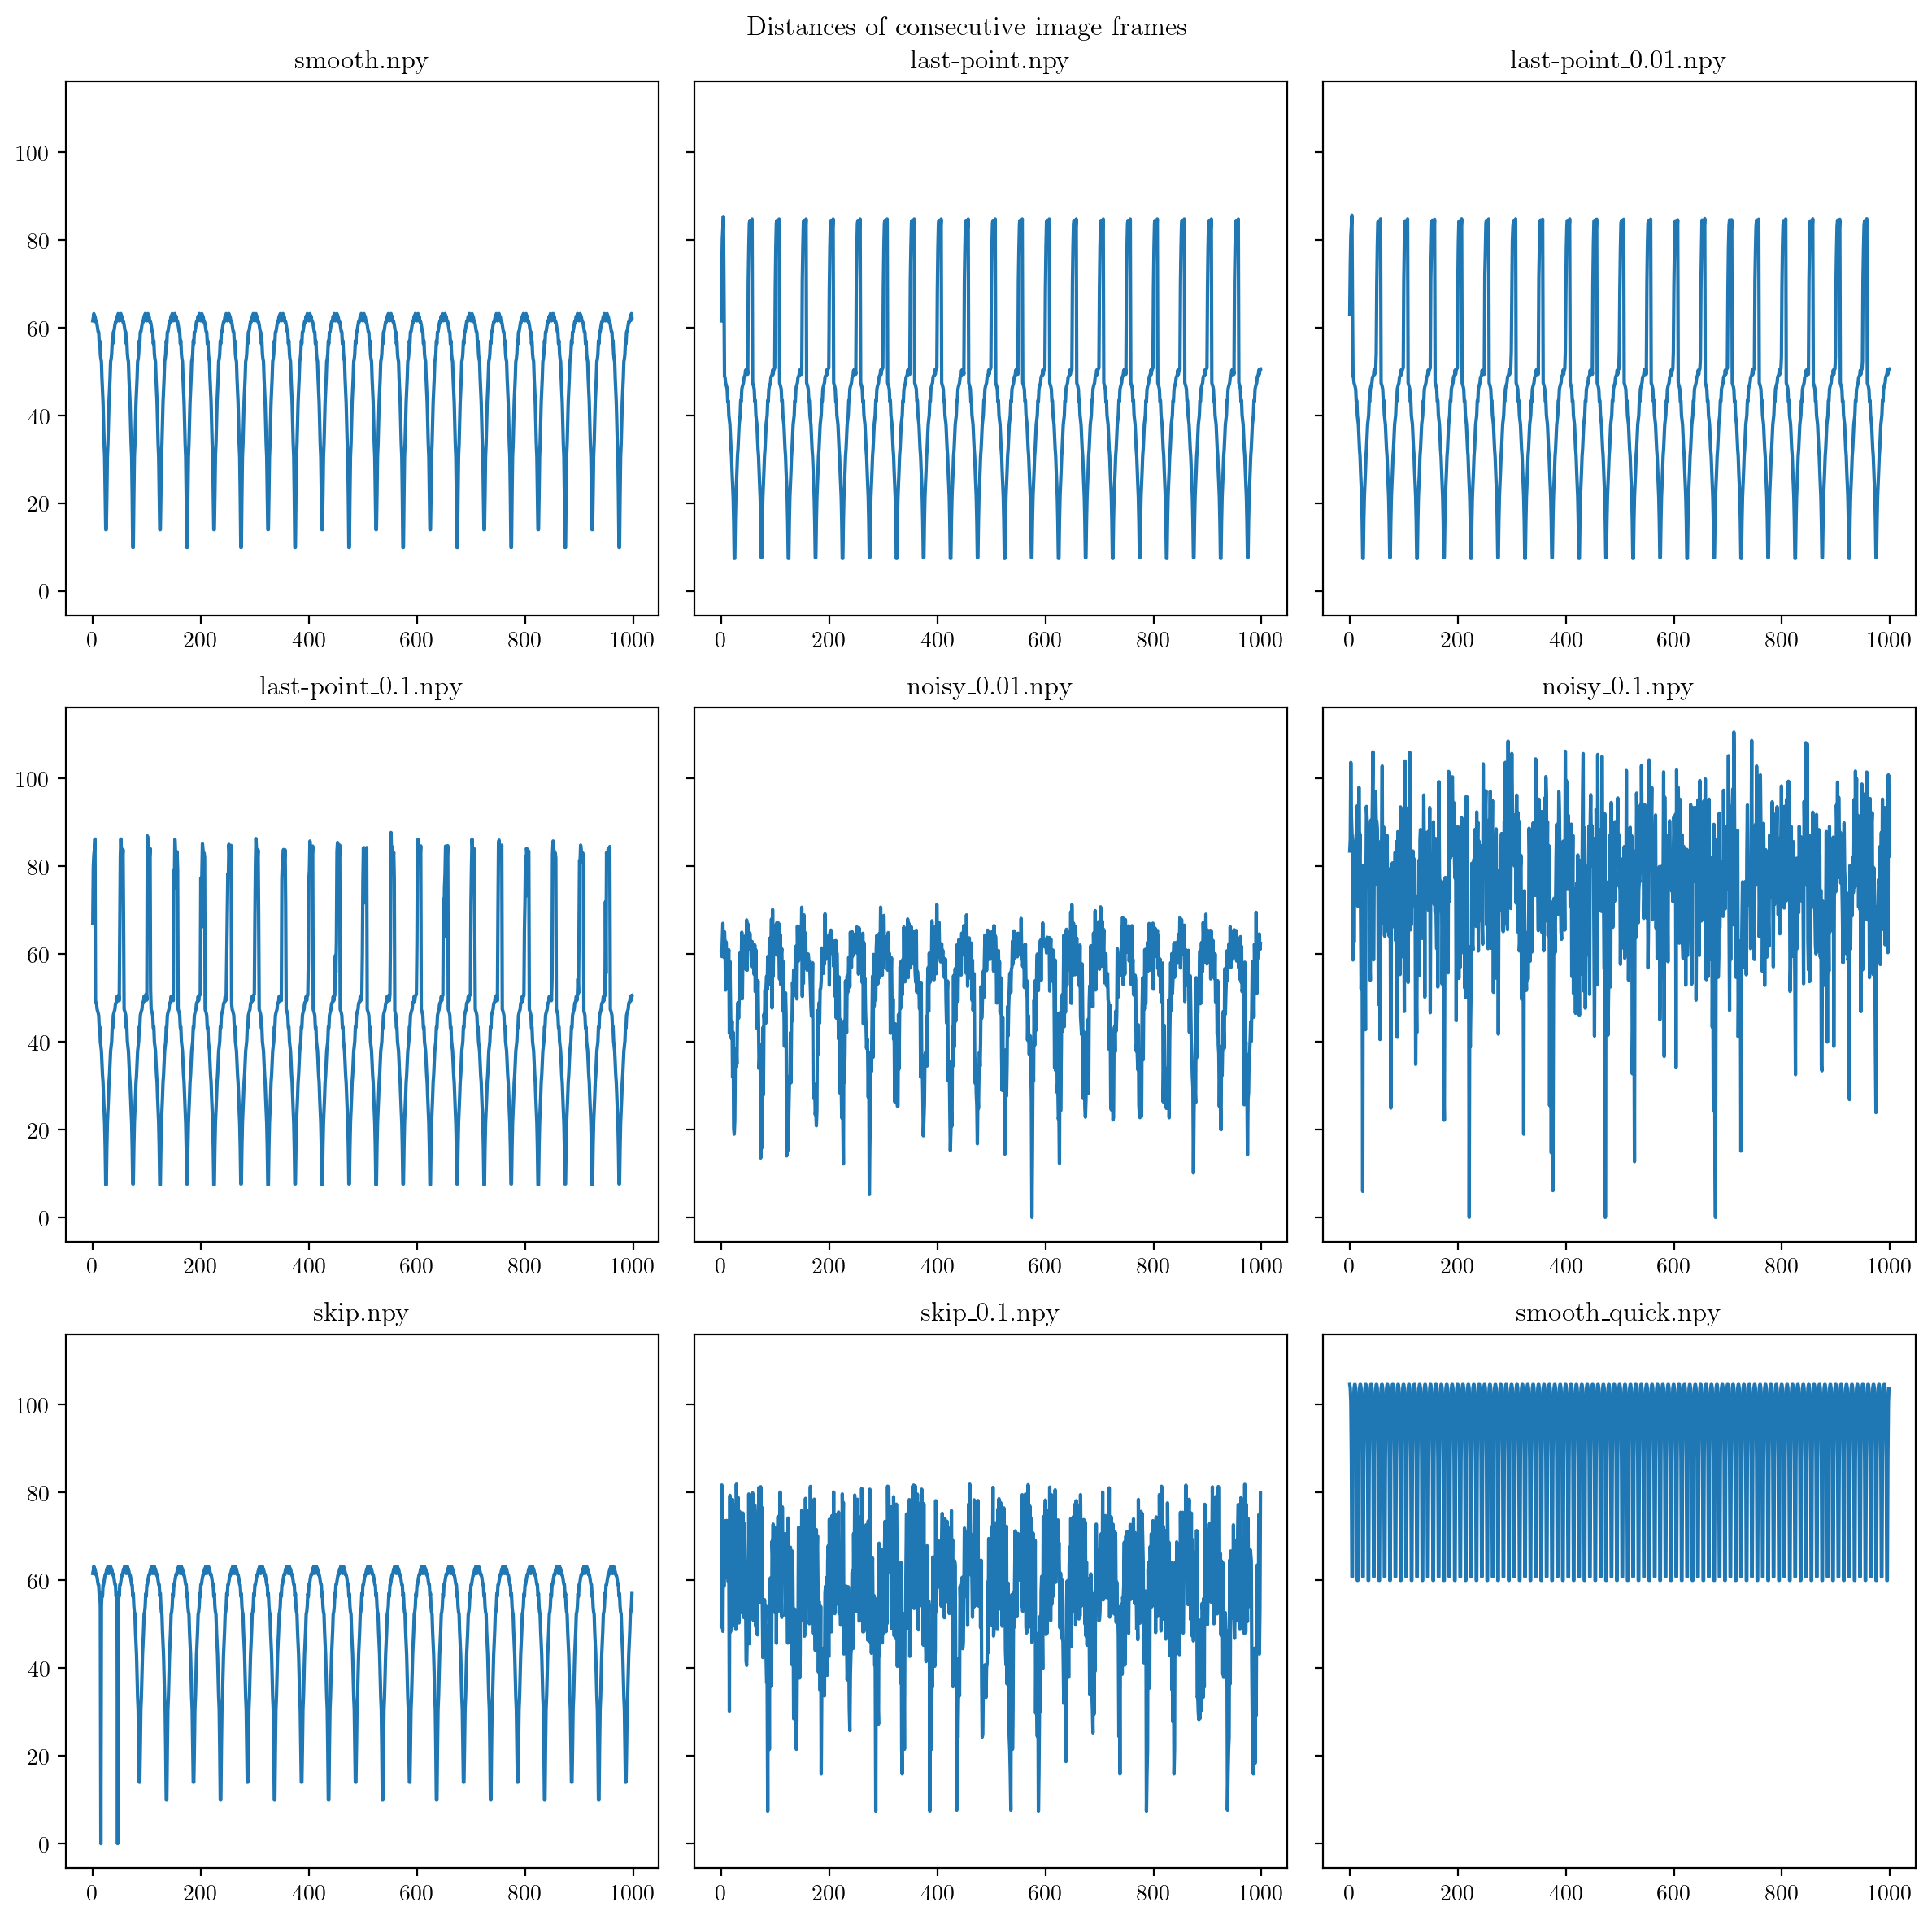

In [77]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].plot(range(len(l2[i])), l2[i])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Distances of consecutive image frames')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_distance_bw_consecutive_frames.png'))

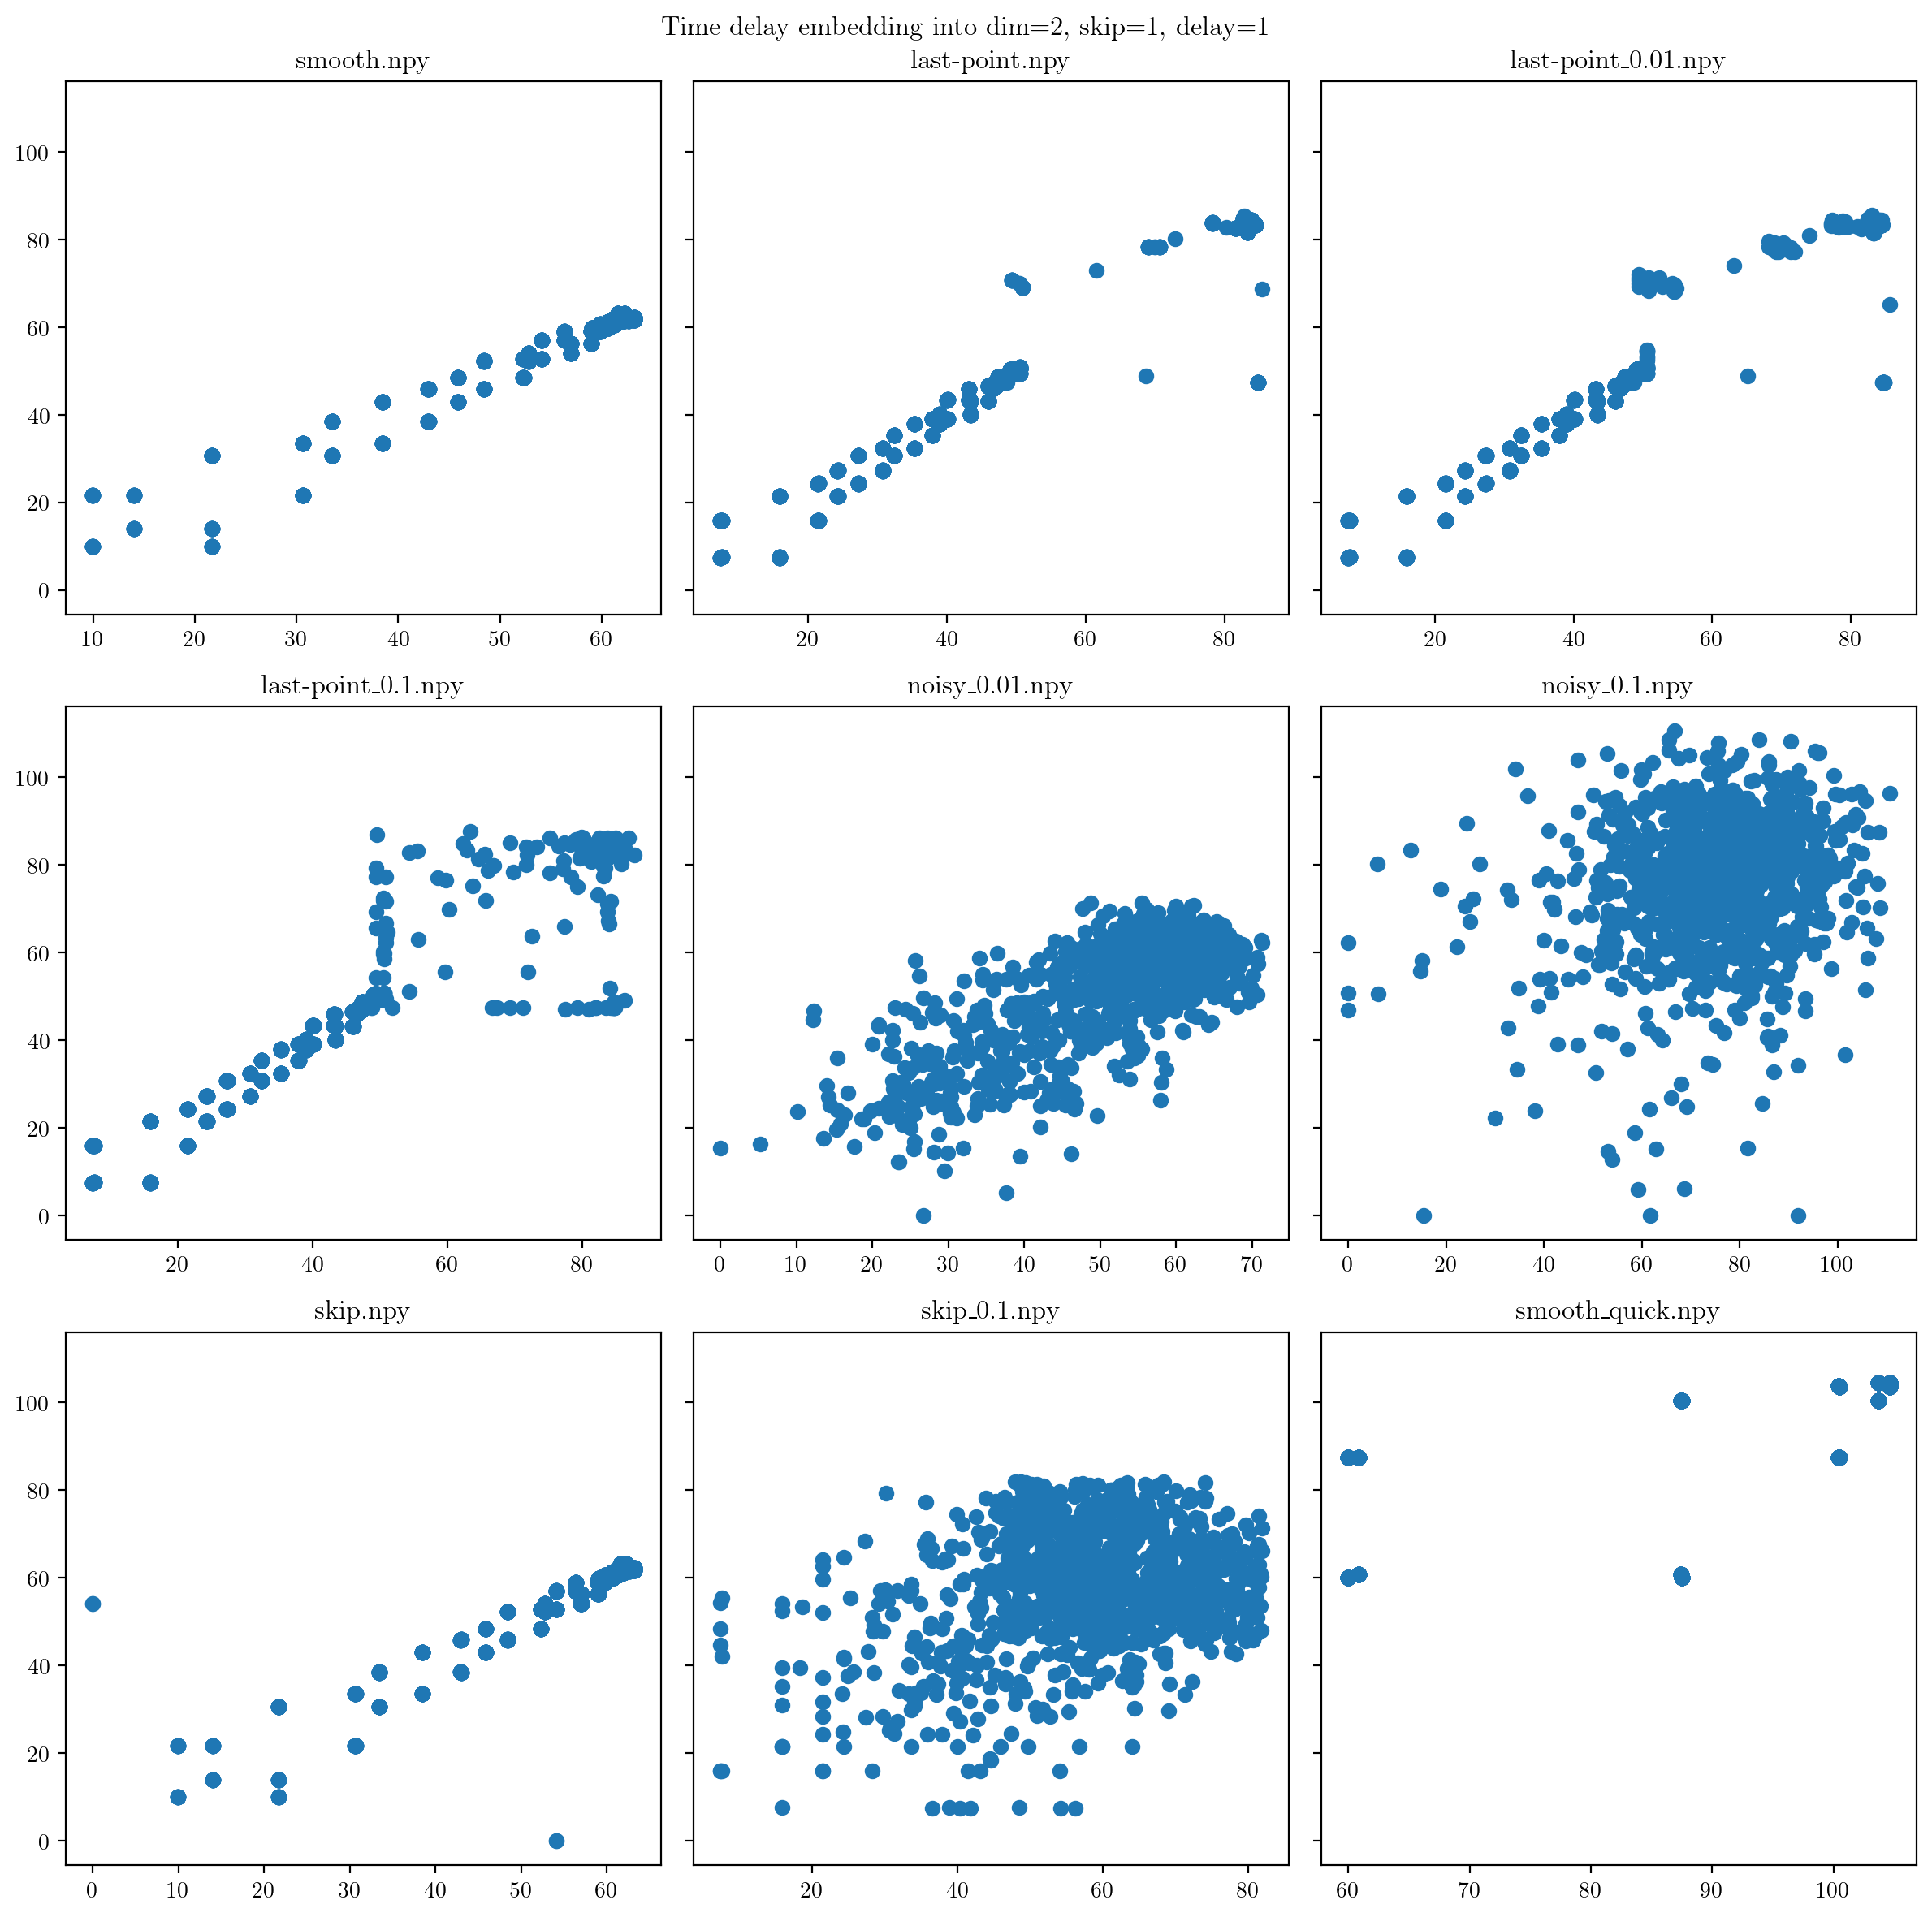

In [78]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].scatter(pc_taken[i][:, 0], pc_taken[i][:, 1])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Time delay embedding into dim=2, skip=1, delay=1')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_time_delay_consecutive_frames.png'))

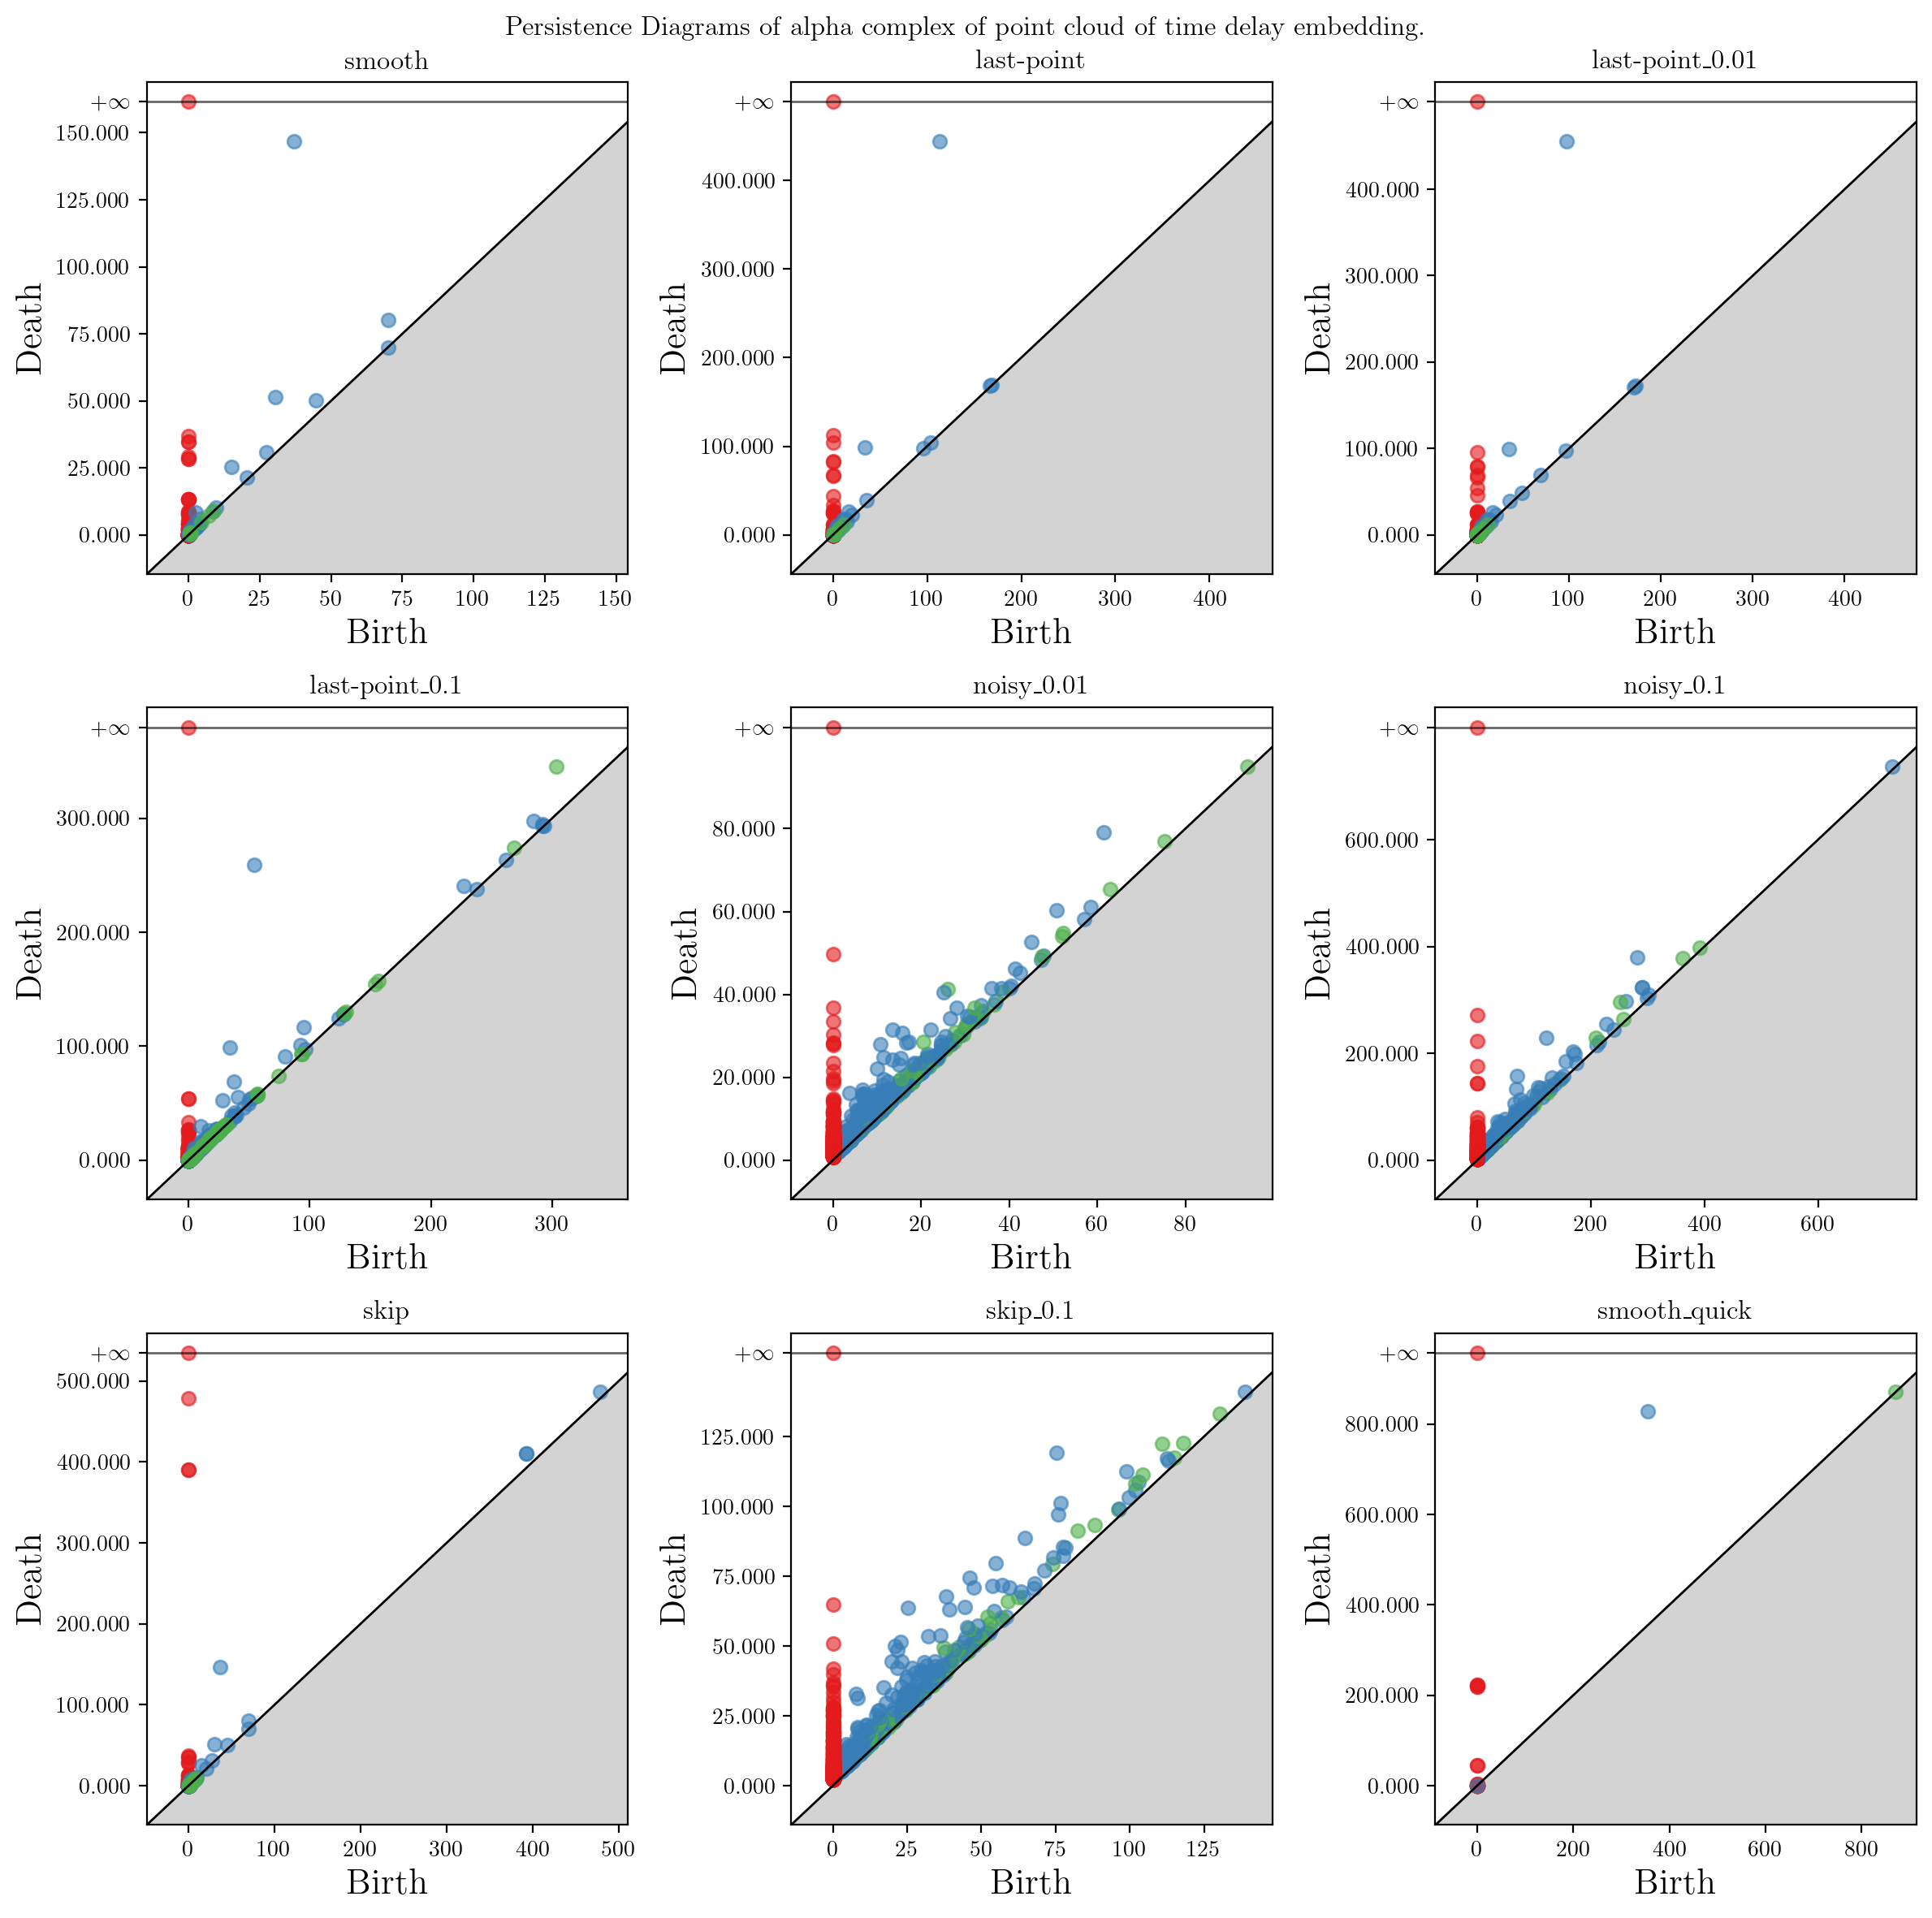

In [79]:
# fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)
fig, ax_list = create_fig(samples_all, dpi=200)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'images_consecutive_alphacomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of alpha complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_alpha_timedelay.png'))

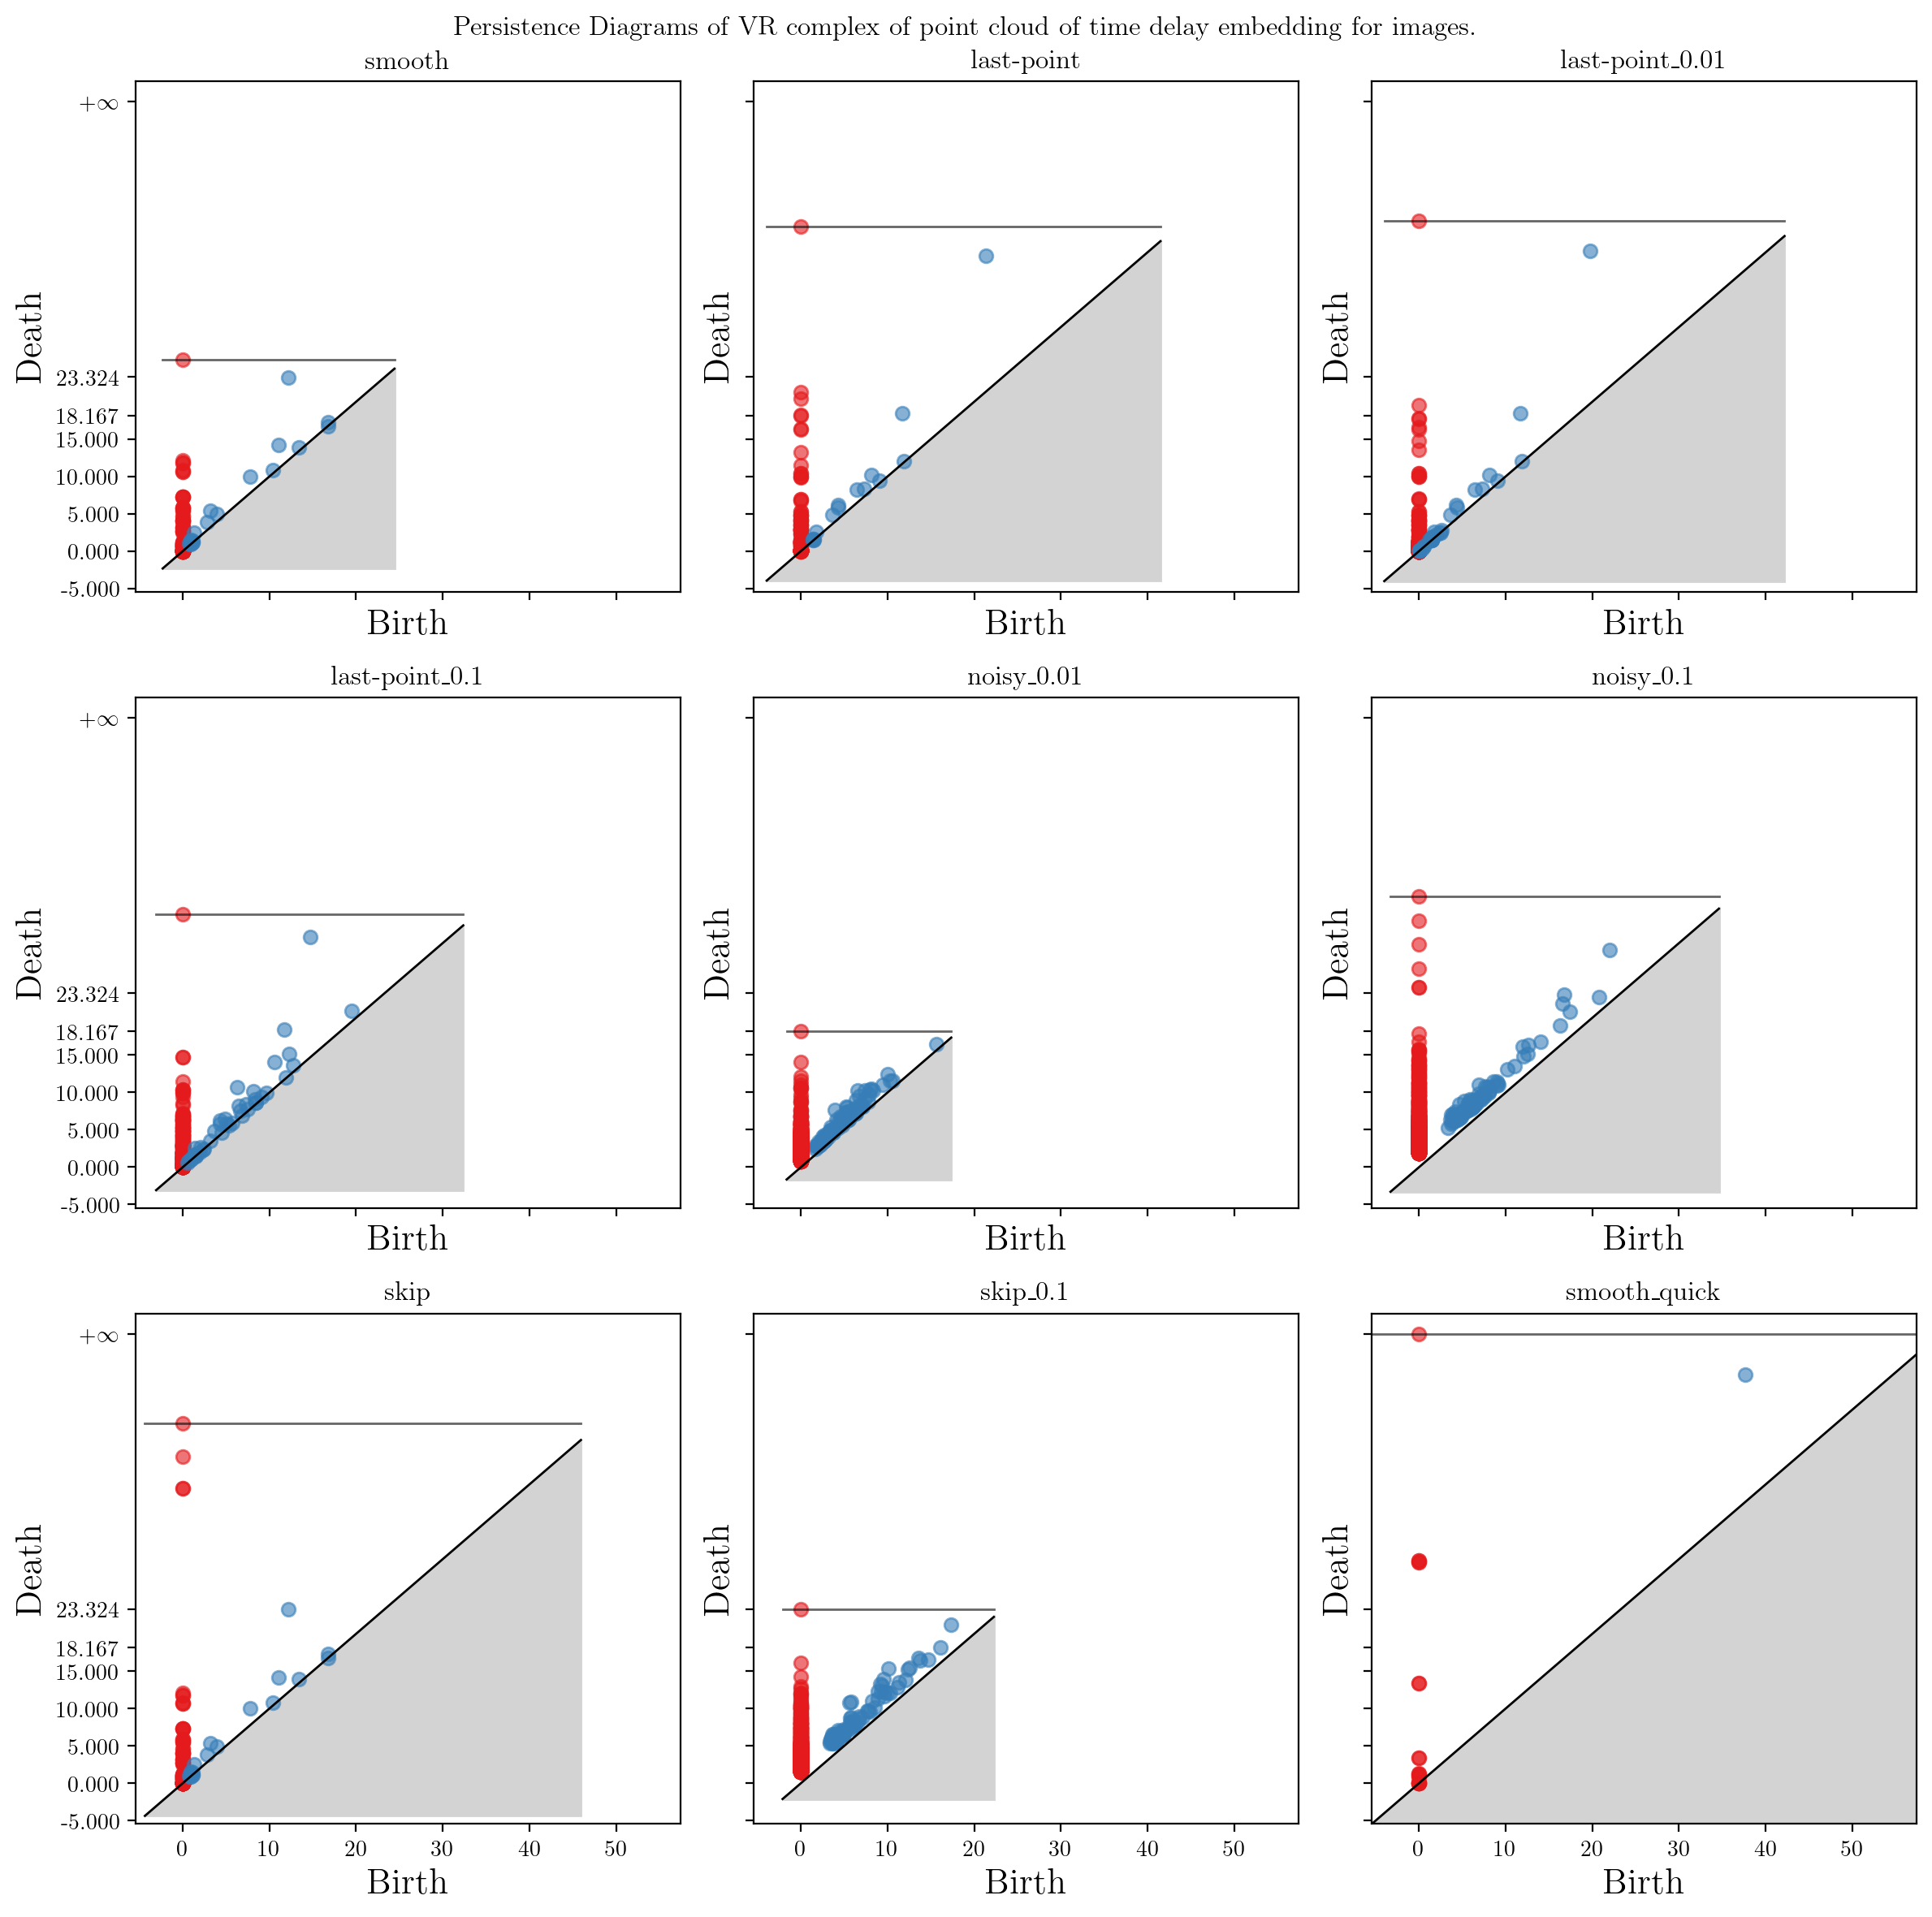

In [80]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'images_consecutive_VRcomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of VR complex of point cloud of time delay embedding for images.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_VR_timedelay.png'))

In [81]:
## COMUPYTING TAKES TOO LONG RIGHT NOW!
# fig, ax_list = create_fig(samples_all[:2], dpi=200, sharey=True, sharex=True)

# diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
#                                 'images_distamtrix_VRcomplex.npz'))

# for i, key in enumerate(diagrams.keys()):
#     dgmX = diagram_convert(diagrams[key])
#     gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
#     ax_list[i].set_title(key)

# for i in range(len(diagrams.keys()), len(ax_list)):
#     ax_list[i].remove()

# fig.suptitle('Persistence Diagrams of vietoris rips complex'
#              + ' of distance point cloud.')
# fig.tight_layout()
# fig.savefig(os.path.join(data_folder, 'plots', 'img_VR_pwDistances.png'))